# GLM dev
- "Kernel" GLM: Gaussian GLM with L2 regularization
- Kernel dropouts for "unique" contribution
- 4 different models
    - touch, whisker, touch-answer, whisker-answer
- Design matrix same as before
    - Try dividing answer lick onset, reward lick onset, and other licks
        - See how much better the model gets
- (consider) Multicolinearity test
- Perform per plane
- Refer Alex's code

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt

base_dir = Path(r'E:\TPM\JK\h5')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]

In [447]:
use_mice_df

,Unnamed: 0.1,mouse,plane,session,session_type,depth_matched,processing_error,remove_frame_ind
0,0,25,1,1,training,True,False,0
1,1,25,1,2,training,True,False,0
2,2,25,1,3,training,True,False,0
3,3,25,1,4,test_naive,True,False,0
4,4,25,1,5,training,True,False,0
...,...,...,...,...,...,...,...,...
1452,1452,52,8,16,training,True,False,0
1453,1453,52,8,17,training,True,False,[ 0 109]
1454,1454,52,8,18,training,True,False,0
1456,1456,52,8,20,training,True,False,0


# Design matrix dev
- using refined_frame_time.pkl
- parameters:
    - touch: 0-2 frames (2 angles)
    - whisking: -2-4 frames (number of whisks, whisking amplitude, midpoint)
        - These are not calculated yet. Add.
    - licking: -2-2 frames (left and right)
    - sound cue: 0-4 frames (single)
    - rewards: 0-4 frames (single)

In [2]:
mouse = 25
plane = 1
session = 3
plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')


In [ ]:
behavior_frametime.head()

,trialNum,frame_start_time,frame_end_time,trial_duration,frame_index,kappaH_onset,kappaV_onset,phi_onset,theta_onset,arc_length_onset,...,first_reward_lick_right,correct,wrong,miss,trial_type,task_target,distractor,mouse_name,session_name,session_type
0,2,0.221688,0.254117,6.101034,0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,rn,Angle,Off,JK025,S03,2port-Discrim
1,2,0.351407,0.383836,6.101034,1,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,rn,Angle,Off,JK025,S03,2port-Discrim
2,2,0.481125,0.513555,6.101034,2,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,rn,Angle,Off,JK025,S03,2port-Discrim
3,2,0.610844,0.643274,6.101034,3,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,rn,Angle,Off,JK025,S03,2port-Discrim
4,2,0.740563,0.772993,6.101034,4,NaN,NaN,NaN,NaN,NaN,...,False,False,False,True,rn,Angle,Off,JK025,S03,2port-Discrim


In [ ]:
behavior_frametime.keys()

Index(['trialNum', 'frame_start_time', 'frame_end_time', 'trial_duration',
       'frame_index', 'kappaH_onset', 'kappaV_onset', 'phi_onset',
       'theta_onset', 'arc_length_onset', 'touch_count', 'delta_kappaH',
       'delta_kappaV', 'delta_phi', 'delta_theta', 'slide_distance',
       'touch_duration', 'pole_up_frame', 'pole_moving_frame', 'theta',
       'midpoint', 'amplitude', 'num_whisks', 'pole_angle', 'pole_ap_distance',
       'pole_radial_distance', 'num_lick_left', 'num_lick_right',
       'answer_lick_frame', 'answer_lick_left', 'answer_lick_right',
       'pre_answer_pole_up_frame', 'answer_period_frame',
       'post_answer_pole_up_frame', 'first_reward_lick_frame',
       'first_reward_lick_left', 'first_reward_lick_right', 'correct', 'wrong',
       'miss', 'trial_type', 'task_target', 'distractor', 'mouse_name',
       'session_name', 'session_type'],
      dtype='object')

In [ ]:

behavior_frametime_answered = behavior_frametime[behavior_frametime['miss']==False]
behavior_frametime_answered.groupby('trialNum').apply(lambda x: x['frame_index'].max() - x[x['answer_lick_frame']]['frame_index'].max()).values
# plenty of frames after the answer lick frame

array([14, 14, 15, 14, 15, 15, 14, 15, 15, 15, 14, 15, 14, 15, 14, 15, 15,
       14, 14, 15, 15, 14, 15, 14, 13, 15, 15, 14, 14, 15, 14, 15, 14, 15,
       15, 15, 14, 14, 14, 15, 14, 14, 15, 14, 14, 15, 14, 14, 15, 15, 15,
       15, 14, 15, 14, 14, 14, 15, 14, 15, 15, 15, 15, 14, 15, 15, 15, 14,
       15, 15, 14, 14, 14, 15, 14, 14, 14, 14, 15, 14, 14, 14, 14, 14, 14,
       14, 15, 14, 15, 15, 14, 14, 15, 14, 15, 14, 14, 14, 14, 15, 14, 15,
       15, 14, 14, 15, 15, 15, 15, 14, 15, 14, 14, 15, 15, 15, 14, 14, 14,
       14, 15, 15, 15, 14, 15, 14, 15, 14, 14, 15, 14, 15, 14, 14, 15, 14,
       15, 15, 14, 14, 15, 15, 14, 14, 14, 15, 15, 15, 15, 13, 14, 15, 14,
       14, 14, 14, 15, 15, 15, 15, 15, 14, 14, 15, 15, 14, 15, 14, 14, 15,
       15, 15, 14], dtype=int64)

In [3]:
ophys_frametime.head()

,trialNum,frame_start_time,frame_end_time,trial_duration,frame_index,remove_frame,remove_trial
0,2,0.351407,0.383836,6.101034,1,False,False
1,2,0.481125,0.513555,6.101034,2,False,False
2,2,0.610844,0.643274,6.101034,3,False,False
3,2,0.740563,0.772993,6.101034,4,False,False
4,2,0.870282,0.902712,6.101034,5,False,False


In [4]:
refined_ophys_frametime = ophys_frametime.query('remove_trial==False').reset_index()
assert refined_ophys_frametime.remove_frame.values.sum() == 0

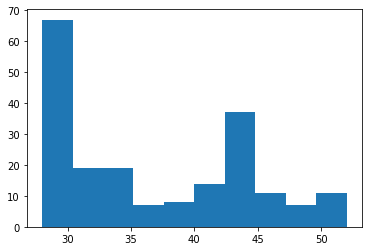

In [5]:
plt.hist(refined_ophys_frametime.groupby('trialNum').apply(len).values);
# plenty of time to get rid of 4 frames
# max 15% of loss
# Would be a little bit more for slower frame rate

In [ ]:
refined_ophys_frametime.keys()

Index(['trialNum', 'frame_start_time', 'frame_end_time', 'trial_duration',
       'frame_index', 'remove_frame', 'remove_trial'],
      dtype='object')

# Making design matrix
- Save each type of design matrix
    - touch model (either 2 or 7 angles), with or without feedback period (before/after answer)
    - whisker model (12 whisker features), with or without feedback period (before/after answer)
    - under "roi" dir, "glm" dir
        - touch_all
        - touch_feedback
        - whisker_all
        - whisker_feedback
- First, extend each trial with -2 and +4
    - Then, assign corresponding frame_time from behavior dataframe
    - Remove those with NaN frames

In [28]:
def extend_dataframe(group):
    before_rows = group.iloc[0:4].copy().reset_index(drop=True)
    before_rows[:] = np.nan
    before_rows.trialNum = group.trialNum.iloc[0]
    before_rows.frame_index = -1
    before_rows.loc[before_rows.index.max(), 'frame_index'] = group.frame_index.min()-1
    after_rows = group.iloc[-4:].copy().reset_index(drop=True)
    after_rows[:] = np.nan
    after_rows.trialNum = group.trialNum.iloc[-1]
    after_rows.frame_index = -1
    after_rows.loc[0,'frame_index'] = group.frame_index.max()+1
    extended_group = pd.concat([before_rows, group, after_rows], ignore_index=True)
    return extended_group

extended_ophys_df = refined_ophys_frametime.groupby('trialNum').apply(extend_dataframe).reset_index(drop=True)




In [7]:
reduced_behavior_columns = np.setdiff1d(behavior_frametime.columns,np.setdiff1d(extended_ophys_df.columns, ['trialNum', 'frame_index']))
reduced_behavior_df = behavior_frametime[reduced_behavior_columns]
merged_df = pd.merge(extended_ophys_df, reduced_behavior_df, on=['trialNum', 'frame_index'], how='outer')
    # Here outer join is to keep behavior data preceeding and following ophys frames
constant_columns = ['correct', 'wrong', 'miss', 'trial_type', 'task_target', 'distractor', 'mouse_name', 'session_name', 'session_type', 'trial_duration']


In [ ]:
temp = merged_df[['trialNum', 'frame_index', 'touch_count']]

In [ ]:
behavior_frametime.trial_type.unique()

array(['rn', 'ln'], dtype=object)

In [8]:
# Assigne pole_moving_up and pole_moving_down to the frames
# First check if all trials have correct pole up pole moving frames
# Sometimes there is no pole_moving_frame
# Just use -1 of the first pole up and the last of pole up frame as pole_in_frame and pole_out_frame
assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame']==1)[0])==0).any()
merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==True)[0][0]-1]).reset_index(drop=True).values
merged_df['pole_out_frame'] = merged_df.groupby('trialNum').apply(lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==True)[0][-1]]).reset_index(drop=True).values



In [9]:
angles = merged_df['pole_angle'].unique()
angles = angles[~np.isnan(angles)].astype(int)
lick_names = ['num_lick_left', 'num_lick_right']
whisking_names = ['num_whisks', 'midpoint', 'amplitude']
reward_names = ['first_reward_lick_left', 'first_reward_lick_right']
sound_names = ['pole_in_frame', 'pole_out_frame']
touch_names = []

# add specific angle touch
for angle in angles:
    touch_names.append(f'touch_count_{angle}')
    merged_df[f'touch_count_{angle}'] = np.nan
    merged_df.loc[merged_df['pole_angle']==angle, f'touch_count_{angle}'] = merged_df.loc[merged_df['pole_angle']==angle, 'touch_count']
    merged_df[f'touch_count_{angle}'] = merged_df[f'touch_count_{angle}'].apply(lambda x: 0 if np.isnan(x) else x)


In [18]:
merged_df.groupby('trialNum').apply(lambda x: x[f'touch_count_{angle}'].shift(offset)).reset_index(drop=True).values

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
design_df = merged_df[['trialNum','frame_index']].copy()
design_df['new_colum'] = False

In [29]:
touch_offsets = np.arange(0,3)
whisking_offsets = np.arange(-2,5)
lick_offsets = np.arange(-2,3)
sound_offsets = np.arange(0,5)
reward_offsets = np.arange(0,5)

design_df = merged_df[['trialNum','frame_index']].copy()
for angle in angles:
    for offset in touch_offsets:
        values_to_assign = merged_df.groupby('trialNum').apply(lambda x: x[f'touch_count_{angle}'].shift(offset)).reset_index(drop=True).values
        assert len(values_to_assign) == len(design_df)
        design_df[f'touch_count_{angle}_{offset}'] = values_to_assign
for whisking_name in whisking_names:
    for offset in whisking_offsets:
        values_to_assign = merged_df.groupby('trialNum').apply(lambda x: x[whisking_name].shift(offset)).reset_index(drop=True).values
        assert len(values_to_assign) == len(design_df)
        design_df.loc[:,f'{whisking_name}_{offset}'] = values_to_assign
for lick_name in lick_names:
    for offset in lick_offsets:
        values_to_assign = merged_df.groupby('trialNum').apply(lambda x: x[lick_name].shift(offset)).reset_index(drop=True).values
        assert len(values_to_assign) == len(design_df)
        design_df.loc[:,f'{lick_name}_{offset}'] = values_to_assign
for sound_name in sound_names:
    for offset in sound_offsets:
        values_to_assign = merged_df.groupby('trialNum').apply(lambda x: x[sound_name].shift(offset)).reset_index(drop=True).values
        assert len(values_to_assign) == len(design_df)
        design_df.loc[:,f'{sound_name}_{offset}'] = values_to_assign
for reward_name in reward_names:
    for offset in reward_offsets:
        values_to_assign = merged_df.groupby('trialNum').apply(lambda x: x[reward_name].shift(offset)).reset_index(drop=True).values
        assert len(values_to_assign) == len(design_df)
        design_df.loc[:,f'{reward_name}_{offset}'] = values_to_assign

In [ ]:
# check visually
touch_tns = merged_df.groupby('trialNum').apply(lambda x: np.isfinite(x.touch_count.values).any())
touch_tns = touch_tns[touch_tns.values].index.values
nontouch_tns = merged_df.groupby('trialNum').apply(lambda x: x['touch_count'].isna().all())
nontouch_tns = nontouch_tns[nontouch_tns.values].index.values
assert len(np.intersect1d(touch_tns, nontouch_tns)) == 0
assert len(np.union1d(touch_tns, nontouch_tns)) == len(merged_df['trialNum'].unique())

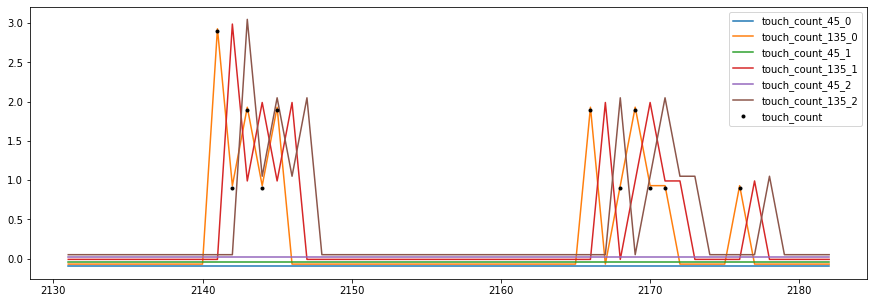

In [ ]:
tn = touch_tns[50]
# tn = nontouch_tns[-1]
temp_merged_df = merged_df.loc[merged_df['trialNum']==tn]
temp_design_df = design_df.loc[design_df['trialNum']==tn]
fig, ax = plt.subplots(figsize=(15,5))

x_inds = np.where(temp_design_df.frame_index>=0)[0]
yoffset = -0.1
for offset in touch_offsets:
    for angle in angles:
        ax.plot(temp_design_df['frame_index'].values[x_inds],
                temp_design_df[f'touch_count_{angle}_{offset}'].values[x_inds] + yoffset,
                label=f'touch_count_{angle}_{offset}')
        yoffset += 0.03
ax.plot(temp_merged_df['frame_index'].values[x_inds],
        temp_merged_df['touch_count'].values[x_inds]-0.1,  '.',
        label='touch_count', color='k')
ax.legend()



In [ ]:
merged_df.keys()

Index(['trialNum', 'frame_start_time', 'frame_end_time', 'trial_duration',
       'frame_index', 'remove_frame', 'remove_trial', 'amplitude',
       'answer_lick_frame', 'answer_lick_left', 'answer_lick_right',
       'answer_period_frame', 'arc_length_onset', 'correct', 'delta_kappaH',
       'delta_kappaV', 'delta_phi', 'delta_theta', 'distractor',
       'first_reward_lick_frame', 'first_reward_lick_left',
       'first_reward_lick_right', 'kappaH_onset', 'kappaV_onset', 'midpoint',
       'miss', 'mouse_name', 'num_lick_left', 'num_lick_right', 'num_whisks',
       'phi_onset', 'pole_angle', 'pole_ap_distance', 'pole_moving_frame',
       'pole_radial_distance', 'pole_up_frame', 'post_answer_pole_up_frame',
       'pre_answer_pole_up_frame', 'session_name', 'session_type',
       'slide_distance', 'task_target', 'theta', 'theta_onset', 'touch_count',
       'touch_duration', 'trial_type', 'wrong', 'pole_in_frame',
       'pole_out_frame', 'touch_count_45', 'touch_count_135'],
     

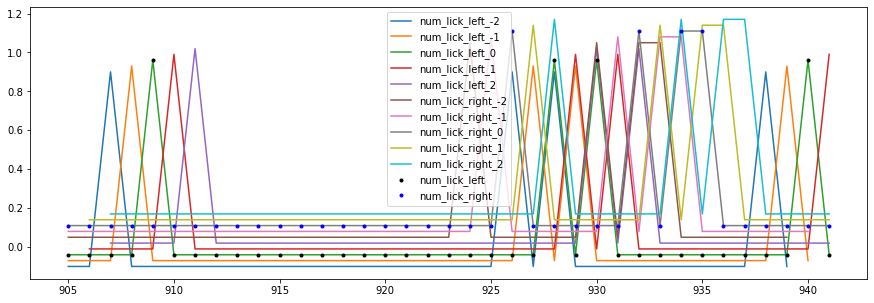

In [ ]:
# check lick
tn = touch_tns[20]

temp_merged_df = merged_df.loc[merged_df['trialNum']==tn]
temp_design_df = design_df.loc[design_df['trialNum']==tn]
fig, ax = plt.subplots(figsize=(15,5))
x_inds = np.where(temp_design_df.frame_index>=0)[0]
yoffset = -0.1
for lick_name in lick_names:
    for offset in lick_offsets:
        ax.plot(temp_design_df['frame_index'].values[x_inds],
                temp_design_df[f'{lick_name}_{offset}'].values[x_inds] + yoffset,
                label=f'{lick_name}_{offset}')
        yoffset += 0.03

ax.plot(temp_merged_df['frame_index'].values[x_inds],
        temp_merged_df['num_lick_left'].values[x_inds] -0.04,  'k.', label='num_lick_left')
ax.plot(temp_merged_df['frame_index'].values[x_inds],
        temp_merged_df['num_lick_right'].values[x_inds] + 0.11,  'b.', label='num_lick_right')

ax.legend()

### Make a function and QC other mice and sessions

In [38]:
def make_design_dataframe(mouse, plane, session, base_dir,
                          touch_offsets=np.arange(0,3),
                          whisking_offsets=np.arange(-2,5),
                          lick_offsets=np.arange(-2,3),
                          sound_offsets=np.arange(0,5),
                          reward_offsets=np.arange(0,5)):
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    behavior_fn = plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl'
    if not behavior_fn.exists():
        raise FileNotFoundError(f'{behavior_fn} does not exist')
    behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
    roi_dir = plane_dir / f'{session:03}/plane0/roi'
    ophys_fn = roi_dir / 'refined_frame_time.pkl'
    if not ophys_fn.exists():
        raise FileNotFoundError(f'{ophys_fn} does not exist')
    ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

    # remove those with remove_trial==True (from expert_mice.csv)
    refined_ophys_frametime = ophys_frametime.query('remove_trial==False')
    assert refined_ophys_frametime.remove_frame.values.sum() == 0
    # extend each trial frames by 1 in each direction (those trimmed to make reduced_frame_time.pkl from frame_time.pkl)
    # so that I can have 2 more frame of information (from behavior_frametime)
    extended_ophys_df = refined_ophys_frametime.groupby('trialNum').apply(extend_dataframe).reset_index(drop=True)

    # merge with behavior_frametime
    reduced_behavior_columns = np.setdiff1d(behavior_frametime.columns,
                                            np.setdiff1d(extended_ophys_df.columns,
                                                         ['trialNum', 'frame_index']))
    reduced_behavior_df = behavior_frametime[reduced_behavior_columns]
    merged_df = pd.merge(extended_ophys_df, reduced_behavior_df,
                         on=['trialNum', 'frame_index'], how='inner')

    # remove catch trials
    catch_trial_nums = merged_df.query('trial_type == "oo"')['trialNum'].unique()
    merged_df = merged_df.query('trialNum not in @catch_trial_nums').reset_index().copy()
    assert 'oo' not in merged_df['trial_type'].unique()
    
    # Assign pole in sound and pole out sound cue frames
    assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame']==1)[0])==0).any()
    merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==True)[0][0]-1]).reset_index(drop=True).values    
    merged_df['pole_out_frame'] = merged_df.groupby('trialNum').apply(apply_pole_out).reset_index(drop=True).values

    # Initialize names
    angles = merged_df['pole_angle'].unique()
    angles = angles[~np.isnan(angles)].astype(int)
    lick_names = ['num_lick_left', 'num_lick_right']
    whisking_names = ['num_whisks', 'midpoint', 'amplitude']
    reward_names = ['first_reward_lick_left', 'first_reward_lick_right']
    sound_names = ['pole_in_frame', 'pole_out_frame']
    touch_names = []

    # add specific angle touch
    for angle in angles:
        touch_names.append(f'touch_count_{angle}')
        merged_df[f'touch_count_{angle}'] = np.nan
        merged_df.loc[merged_df['pole_angle']==angle, f'touch_count_{angle}'] = merged_df.loc[merged_df['pole_angle']==angle, 'touch_count'].values
        merged_df[f'touch_count_{angle}'] = merged_df[f'touch_count_{angle}'].apply(lambda x: 0 if np.isnan(x) else x)

    # Build design dataframe
    design_df = merged_df[['trialNum','frame_index']].copy()
    for angle in angles:
        for offset in touch_offsets:
            design_df[f'touch_count_{angle}_{offset}'] = merged_df.groupby('trialNum').apply(lambda x: x[f'touch_count_{angle}'].shift(offset)).reset_index(drop=True).values
    for whisking_name in whisking_names:
        for offset in whisking_offsets:
            design_df[f'{whisking_name}_{offset}'] = merged_df.groupby('trialNum').apply(lambda x: x[whisking_name].shift(offset)).reset_index(drop=True).values
    for lick_name in lick_names:
        for offset in lick_offsets:
            design_df[f'{lick_name}_{offset}'] = merged_df.groupby('trialNum').apply(lambda x: x[lick_name].shift(offset)).reset_index(drop=True).values
    for sound_name in sound_names:
        for offset in sound_offsets:
            design_df[f'{sound_name}_{offset}'] = merged_df.groupby('trialNum').apply(lambda x: x[sound_name].shift(offset)).reset_index(drop=True).values
    for reward_name in reward_names:
        for offset in reward_offsets:
            design_df[f'{reward_name}_{offset}'] = merged_df.groupby('trialNum').apply(lambda x: x[reward_name].shift(offset)).reset_index(drop=True).values

    return design_df, merged_df


def extend_dataframe(group, n_before=1, n_after=1):
    before_rows = group.iloc[0:n_before].copy().reset_index(drop=True)
    before_rows[:] = np.nan
    before_rows.trialNum = group.trialNum.iloc[0]
    before_rows.frame_index = -1
    before_rows.loc[before_rows.index.max(), 'frame_index'] = group.frame_index.min()-1
    after_rows = group.iloc[-n_after:].copy().reset_index(drop=True)
    after_rows[:] = np.nan
    after_rows.trialNum = group.trialNum.iloc[-1]
    after_rows.frame_index = -1
    after_rows.loc[0,'frame_index'] = group.frame_index.max()+1
    extended_group = pd.concat([before_rows, group, after_rows], ignore_index=True)
    return extended_group


def apply_pole_out(x):
     if np.where(x['pole_up_frame']==True)[0][-1] < len(x)-1:
          return x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==True)[0][-1]]
     else:
          return pd.Series([False]*len(x))

In [31]:
def qc_design_touch(design_df, merged_df, trial_num, angles, touch_offsets):
    temp_merged_df = merged_df.loc[merged_df['trialNum']==trial_num]
    temp_design_df = design_df.loc[design_df['trialNum']==trial_num]
    fig, ax = plt.subplots(figsize=(15,5))

    x_inds = np.where(temp_design_df.frame_index>=0)[0]
    yoffset = -0.1
    for angle in angles:
        for offset in touch_offsets:
            ax.plot(temp_design_df['frame_index'].values[x_inds],
                    temp_design_df[f'touch_count_{angle}_{offset}'].values[x_inds] + yoffset,
                    label=f'touch_count_{angle}_{offset}')
            yoffset += 0.03

    trial_angle = temp_merged_df.pole_angle.unique()
    trial_angle = trial_angle[~np.isnan(trial_angle)].astype(int)
    angle_ind = np.where(angles == trial_angle)[0][0]
    y_offset = -0.1 + angle_ind*0.03*len(touch_offsets)
    ax.plot(temp_merged_df['frame_index'].values[x_inds],
            temp_merged_df['touch_count'].values[x_inds] + y_offset,  '.',
            label='touch_count', color='k')
    ax.legend()

    return fig, ax

def qc_design_lick(design_df, merged_df, trial_num, lick_names, lick_offsets):
    temp_merged_df = merged_df.loc[merged_df['trialNum']==trial_num]
    temp_design_df = design_df.loc[design_df['trialNum']==trial_num]
    fig, ax = plt.subplots(figsize=(15,5))
    x_inds = np.where(temp_design_df.frame_index>=0)[0]
    yoffset = -0.1
    for lick_name in lick_names:
        for offset in lick_offsets:
            ax.plot(temp_design_df['frame_index'].values[x_inds],
                    temp_design_df[f'{lick_name}_{offset}'].values[x_inds] + yoffset,
                    label=f'{lick_name}_{offset}')
            yoffset += 0.03

    ax.plot(temp_merged_df['frame_index'].values[x_inds],
            temp_merged_df['num_lick_left'].values[x_inds] -0.04,  'k.', label='num_lick_left')
    ax.plot(temp_merged_df['frame_index'].values[x_inds],
            temp_merged_df['num_lick_right'].values[x_inds] + 0.11,  'b.', label='num_lick_right')

    ax.legend()
    return fig, ax

def qc_design_sound(design_df, merged_df, trial_num, sound_names, sound_offsets):
    temp_merged_df = merged_df.loc[merged_df['trialNum']==trial_num]
    temp_design_df = design_df.loc[design_df['trialNum']==trial_num]
    fig, ax = plt.subplots(figsize=(15,5))
    x_inds = np.where(temp_design_df.frame_index>=0)[0]
    yoffset = -0.1
    for sound_name in sound_names:
        for offset in sound_offsets:
            ax.plot(temp_design_df['frame_index'].values[x_inds],
                    temp_design_df[f'{sound_name}_{offset}'].values[x_inds] + yoffset,
                    label=f'{sound_name}_{offset}')
            yoffset += 0.03

    ax.plot(temp_merged_df['frame_index'].values[x_inds],
            temp_merged_df['pole_in_frame'].values[x_inds] - 0.1 - sound_offsets[0]*0.03,
            'k.', label='pole_in_frame')
    ax.plot(temp_merged_df['frame_index'].values[x_inds],
            temp_merged_df['pole_out_frame'].values[x_inds] - 0.1 - (sound_offsets[0]-len(sound_offsets))*0.03,
            'b.', label='pole_out_frame')

    ax.legend()
    return fig, ax

In [32]:
mouse = 52
plane = 3
use_mice_df.query('mouse == @mouse and plane == @plane').session.unique()

array(['3', '6', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '20', '21'], dtype=object)

In [39]:
session = 15
design_df, merged_df = make_design_dataframe(mouse, plane, session, base_dir)

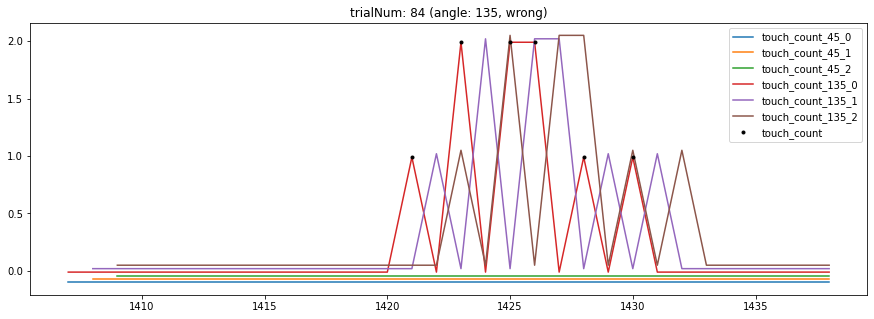

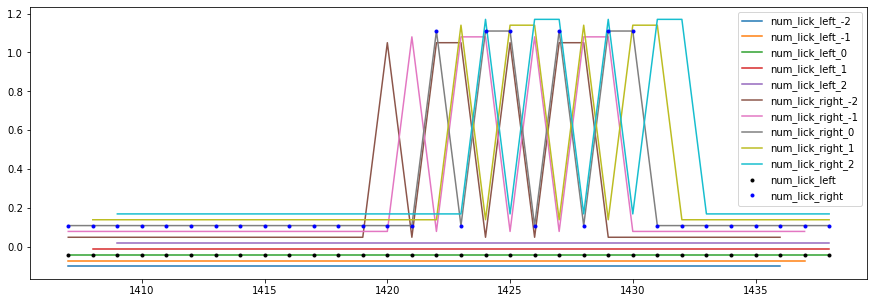

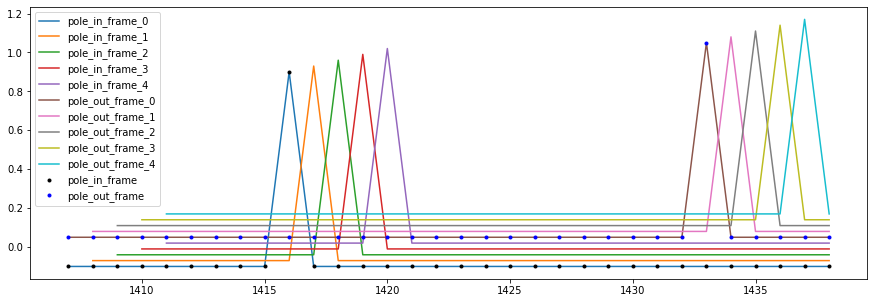

In [ ]:
tn = design_df['trialNum'].unique()[36]
angle = merged_df.loc[merged_df['trialNum']==tn, 'pole_angle'].unique()[0]
if merged_df.loc[merged_df['trialNum']==tn, 'correct'].unique()[0]:
    result = 'correct'
elif merged_df.loc[merged_df['trialNum']==tn, 'wrong'].unique()[0]:
    result = 'wrong'
elif merged_df.loc[merged_df['trialNum']==tn, 'miss'].unique()[0]:
    result = 'miss'
else:
    raise ValueError('No result')

angles = merged_df['pole_angle'].unique()
touch_offsets = np.arange(0,3)
fig, ax = qc_design_touch(design_df, merged_df, tn, angles, touch_offsets)
ax.set_title(f'trialNum: {tn} (angle: {angle}, {result})')

lick_names = ['num_lick_left', 'num_lick_right']
lick_offsets = np.arange(-2,3)
fig, ax = qc_design_lick(design_df, merged_df, tn, lick_names, lick_offsets)

sound_names = ['pole_in_frame', 'pole_out_frame']
sound_offsets = np.arange(0,5)
fig, ax = qc_design_sound(design_df, merged_df, tn, sound_names, sound_offsets)

### JK036 and 039 show errors
- Why?
- It was due to .loc assignment (without .values)

# Save touch-combined design matrices


In [ ]:
# Expected to run for 7 * 704 sec = 4928 sec = 82 min
from tqdm.notebook import tqdm
for i, row in tqdm(use_mice_df.iterrows()):
    mouse = row['mouse']
    plane = row['plane']
    session = int(row['session'])
    design_df, _ = make_design_dataframe(mouse, plane, session, base_dir)
    save_dir = base_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi/glm/touch_combined'
    save_dir.mkdir(exist_ok=True, parents=True)
    design_df.to_pickle(save_dir / 'design.pkl')

# Try Running GLM in one of the sessions

In [4]:
mouse = 30
plane = 2
use_mice_df.query('mouse == @mouse and plane == @plane').session.unique()

array(['1', '2', '3', '5', '12', '18', '19', '20', '21'], dtype=object)

In [5]:
session = 12
roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
glm_dir = roi_dir / 'glm/touch_combined'
design_df = pd.read_pickle(glm_dir / 'design_touch_combined.pkl')

touch_names = [key for key in design_df.keys() if 'touch_count' in key]
whisking_names = [key for key in design_df.keys() if ('num_whisks' in key) or ('midpoint' in key) or ('amplitude' in key)]
lick_names = [key for key in design_df.keys() if 'num_lick' in key]
sound_names = [key for key in design_df.keys() if 'pole_in_frame' in key or 'pole_out_frame' in key]
reward_names = [key for key in design_df.keys() if 'first_reward_lick' in key]

In [22]:
spks = np.load(roi_dir / 'spks_reduced.npy')
iscell = np.load(roi_dir / 'iscell.npy')
cell_inds = np.where(iscell[:,0]==1)[0]
spks = spks[cell_inds,:]
norm_spks = (spks - spks.mean(axis=1)[:,np.newaxis]) / spks.std(axis=1)[:,np.newaxis]
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')
assert len(ophys_frametime) == spks.shape[1]

# filter out rows from design_df
# those with NaN values
# those that are not in ophys_frametime (trialNum, frame_index)
keep_ind = np.where(np.isnan(np.sum(design_df.values, axis=1).astype(float))==False)[0]
filtered_design_df = design_df.iloc[keep_ind]
feature_namebase_to_standardize = ['touch_count', 'num_lick', 'num_whisks', 'midpoint', 'amplitude']
feature_names_to_standardize = [design_column for design_column in filtered_design_df.columns if any([namebase in design_column for namebase in feature_namebase_to_standardize])]
for feature_name in feature_names_to_standardize:
    design_df[feature_name] = (design_df[feature_name] - design_df[feature_name].mean()) / design_df[feature_name].std()
filtered_design_df = filtered_design_df.query('trialNum in @ophys_frametime.trialNum and frame_index in @ophys_frametime.frame_index')
filtered_design_df = filtered_design_df.reset_index(drop=True)
assert len(filtered_design_df.frame_index.unique()) == len(filtered_design_df)
assert np.isin(filtered_design_df.frame_index.values, ophys_frametime.frame_index.values).all()

spks_frame_inds = np.where(np.isin(ophys_frametime.frame_index.values, filtered_design_df.frame_index.values))[0]
assert len(spks_frame_inds) == len(filtered_design_df)
traces = spks[:,spks_frame_inds].T
norm_traces = norm_spks[:,spks_frame_inds].T

# Now traces are in shape of (n_frames, n_cells)

# Standardization
# No change in touch, lick, reward, sound, num_whisks
# Just for amplitude and midpoint
standardized_names = [key for key in filtered_design_df.keys() if ('midpoint' in key) or ('amplitude' in key)]
for key in standardized_names:
    filtered_design_df[key] = (filtered_design_df[key] - filtered_design_df[key].mean()) / filtered_design_df[key].std()

# Adding the bias column
X = np.hstack((np.ones((len(filtered_design_df),1)), filtered_design_df[touch_names + whisking_names + lick_names + sound_names + reward_names].values)).astype(float)

# Turning into xarray
x = np.hstack((np.ones((len(filtered_design_df),1)), filtered_design_df[touch_names + whisking_names + lick_names + sound_names + reward_names].values)).astype(float)
X = xr.DataArray(x, dims=('index', 'feature'), 
                    coords={'index':filtered_design_df.index.values,
                            'feature':['intercept'] + touch_names + whisking_names + lick_names + sound_names + reward_names})
traces = xr.DataArray(traces, dims=('index', 'cell_id'),
                    coords={'index':filtered_design_df.index.values,
                            'cell_id':cell_inds})
norm_traces = xr.DataArray(norm_traces, dims=('index', 'cell_id'),
                    coords={'index':filtered_design_df.index.values,
                            'cell_id':cell_inds})

In [14]:
filtered_design_df.amplitude_0.max()

8.605508853963284

In [8]:
filtered_design_df.columns

Index(['trialNum', 'frame_index', 'touch_count_135_0', 'touch_count_135_1',
       'touch_count_135_2', 'touch_count_45_0', 'touch_count_45_1',
       'touch_count_45_2', 'num_whisks_-2', 'num_whisks_-1', 'num_whisks_0',
       'num_whisks_1', 'num_whisks_2', 'num_whisks_3', 'num_whisks_4',
       'midpoint_-2', 'midpoint_-1', 'midpoint_0', 'midpoint_1', 'midpoint_2',
       'midpoint_3', 'midpoint_4', 'amplitude_-2', 'amplitude_-1',
       'amplitude_0', 'amplitude_1', 'amplitude_2', 'amplitude_3',
       'amplitude_4', 'num_lick_left_-2', 'num_lick_left_-1',
       'num_lick_left_0', 'num_lick_left_1', 'num_lick_left_2',
       'num_lick_right_-2', 'num_lick_right_-1', 'num_lick_right_0',
       'num_lick_right_1', 'num_lick_right_2', 'pole_in_frame_0',
       'pole_in_frame_1', 'pole_in_frame_2', 'pole_in_frame_3',
       'pole_in_frame_4', 'pole_out_frame_0', 'pole_out_frame_1',
       'pole_out_frame_2', 'pole_out_frame_3', 'pole_out_frame_4',
       'first_reward_lick_left_0', 'f

In [ ]:
feature_namebase_to_standardize = ['touch_count', 'num_lick', 'num_whisks', 'midpoint', 'amplitude']



In [15]:
feature_namebase_to_standardize = ['touch_count', 'num_lick', 'num_whisks', 'midpoint', 'amplitude']
feature_names_to_standardize = [design_column for design_column in filtered_design_df.columns if any([namebase in design_column for namebase in feature_namebase_to_standardize])]

In [21]:
for feature_name in feature_names_to_standardize:
    if np.isnan(filtered_design_df[feature_name].values).any():
        print(f'{feature_name} has NaN values')

In [18]:
for feature_name in feature_names_to_standardize:
    filtered_design_df[feature_name] = (filtered_design_df[feature_name] - filtered_design_df[feature_name].mean()) / filtered_design_df[feature_name].std()

In [16]:
feature_names_to_standardize

['touch_count_135_0',
 'touch_count_135_1',
 'touch_count_135_2',
 'touch_count_45_0',
 'touch_count_45_1',
 'touch_count_45_2',
 'num_whisks_-2',
 'num_whisks_-1',
 'num_whisks_0',
 'num_whisks_1',
 'num_whisks_2',
 'num_whisks_3',
 'num_whisks_4',
 'midpoint_-2',
 'midpoint_-1',
 'midpoint_0',
 'midpoint_1',
 'midpoint_2',
 'midpoint_3',
 'midpoint_4',
 'amplitude_-2',
 'amplitude_-1',
 'amplitude_0',
 'amplitude_1',
 'amplitude_2',
 'amplitude_3',
 'amplitude_4',
 'num_lick_left_-2',
 'num_lick_left_-1',
 'num_lick_left_0',
 'num_lick_left_1',
 'num_lick_left_2',
 'num_lick_right_-2',
 'num_lick_right_-1',
 'num_lick_right_0',
 'num_lick_right_1',
 'num_lick_right_2']

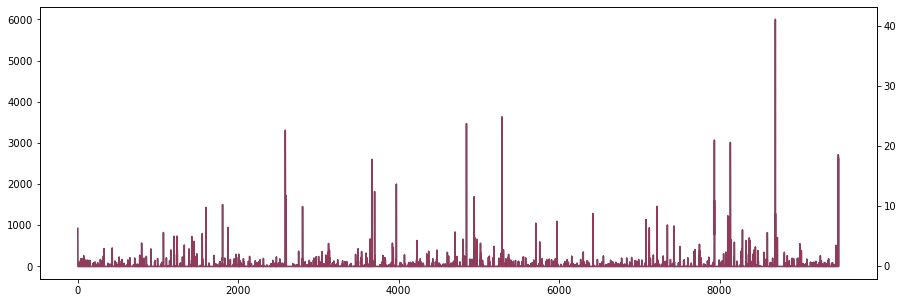

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(spks[0,:])
axx = ax.twinx()
axx.plot(norm_spks[0,:], 'r', alpha=0.5)

In [200]:
lam = 10
w = np.dot(np.linalg.inv(np.dot(X.T, X) + lam * np.eye(X.shape[-1])),
            np.dot(X.T, traces.values))

In [24]:
def fit_glm_gaussian_L2(traces, X, lam):
    '''Fitting Gaussian GLM with L2 regularization
    traces: 2darray (n_frames, n_cells)
    X: n_frames x n_features
    lam: regularization parameter
    ''' 
    w = np.dot(np.linalg.inv(np.dot(X.T, X) + lam * np.eye(X.shape[-1])),
               np.dot(X.T, traces.values))
    if len(w.shape) == 1:
        w = w[:,np.newaxis]
    if len(traces.cell_id.values.shape)==0:
        cell_id = np.array([int(traces.cell_id.values)])
    else:
        cell_id = traces.cell_id.values
    W = xr.DataArray(w, dims=['feature', 'cell_id'],
                     coords={'feature': X.feature.values,
                             'cell_id': cell_id})
    return W


def find_lambda(traces, X, lambda_groups, lam_grid=np.geomspace(0.1, 10000, 100)):
    '''Finding lambda for L2 regularization
    traces: xarray (n_frames, n_cells)
    X: xarray (n_frames x n_features)
    lam_grid: grid of lambda values
    '''
    n_lams = len(lam_grid)
    n_cells = traces.shape[1]
    varexps = np.zeros((n_cells, n_lams, len(lambda_groups)))
    for i, lam in enumerate(lam_grid):
        for j in range(len(lambda_groups)):
            train_inds = np.concatenate([lambda_groups[k] for k in np.setdiff1d(range(len(lambda_groups)), j)])
            test_inds = lambda_groups[j]
            W = fit_glm_gaussian_L2(traces.isel(index=train_inds), X.isel(index=train_inds), lam)
            _, ve = variance_ratio(traces.isel(index=test_inds), W, X.isel(index=test_inds))
            varexps[:, i, j] = ve
    varexps[np.isinf(varexps)] = np.nan
    mean_varexps = np.nanmean(varexps, axis=2)
    return lam_grid[np.argmax(mean_varexps, axis=1)], mean_varexps


def variance_ratio(traces, W, X): 
    '''
    Computes the fraction of variance in traces explained by the linear model Y = X*W
    
    traces: xarray (n_frames, n_cells)
    W: xarray (n_features, n_cells)
    X: xarray (n_frames, n_features)
    '''
    if len(traces.shape) == 1:
        assert len(traces) == X.shape[0]
        trace = traces.values[:,np.newaxis]
    elif len(traces.shape) == 2:
        trace = traces.values
    pred = X.values @ W.values
    ve = 1 - (np.var(trace - pred, axis=0) / np.var(trace, axis=0))
    return pred, ve


In [449]:
len(use_mice_df)

704

In [25]:
# get all the combination of stratification
def stratify(input_inds, n_folds=5):
    inds = input_inds.copy()
    np.random.shuffle(inds)
    groups = np.array_split(inds, n_folds)
    # group_size = len(inds) // n_folds
    # remainder = len(inds) % n_folds
    # if remainder > 0:
    #     groups = [inds[i:i+group_size] for i in range(0, len(inds), group_size)[:-1]]
    #     for i in range(remainder):
    #         groups[i] = np.append(groups[i], inds[-(i+1)])
    # else:
    #     groups = [inds[i:i+group_size] for i in range(0, len(inds), group_size)]
    assert len(groups) == n_folds
    assert len(np.concatenate(groups)) == len(inds)
    return groups


def get_stratified_frame_indice(mouse, plane, session, base_dir, filtered_design_df, n_folds=5):
    # stratification
    # 80% for training, 20% for testing
    # based on trials - touch, angles, task (correct, wrong, miss)
    # within each stratification, randomly divide into 5 folds (of all frames)
    # Do this once for finding lambda, and one for fitting the model
    filtered_design_df.reset_index(drop=True, inplace=True)

    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
    trialNums = filtered_design_df.trialNum.unique()
    behavior_frametime = behavior_frametime.query('trialNum in @trialNums')

    touch_trialNums = behavior_frametime.query("touch_count > 0").trialNum.unique()
    nontouch_trialNums = np.setdiff1d(behavior_frametime.trialNum.unique(), touch_trialNums)
    trialNum_strat_touch = [touch_trialNums, nontouch_trialNums]

    trialNum_strat_angle = []
    angles = behavior_frametime['pole_angle'].unique()
    for angle in angles:
        trialNum_strat_angle.append(behavior_frametime.query('pole_angle == @angle')['trialNum'].unique())

    result_variables = ['correct', 'wrong', 'miss']
    trialNum_strat_result = []
    for result in result_variables:
        trialNum_strat_result.append(behavior_frametime[behavior_frametime[result]].trialNum.unique())

    lambda_groups = []
    fit_groups = []
    all_tns = 0
    for touch_tns in trialNum_strat_touch:
        for angle_tns in trialNum_strat_angle:
            for result_tns in trialNum_strat_result:
                start_tns = np.intersect1d(np.intersect1d(touch_tns, angle_tns), result_tns)
                all_tns += len(start_tns)

                if len(start_tns) > 0:
                    trace_inds = filtered_design_df.query('trialNum in @start_tns').index.values
                    temp_lambda_groups = stratify(trace_inds, n_folds=n_folds)
                    if len(lambda_groups) == 0:
                        lambda_groups = temp_lambda_groups
                    else:
                        lambda_groups = [np.append(lambda_groups[i], temp_lambda_groups[i]) for i in range(n_folds)]
                    temp_fit_groups = stratify(trace_inds, n_folds=n_folds)
                    if len(fit_groups) == 0:
                        fit_groups = temp_fit_groups
                    else:
                        fit_groups = [np.append(fit_groups[i], temp_fit_groups[i]) for i in range(n_folds)]
                    
    assert all_tns == len(filtered_design_df.trialNum.unique())
    # print(len(np.unique(np.concatenate(lambda_groups))), len(np.unique(np.concatenate(fit_groups))), len(filtered_design_df))
    assert len(np.unique(np.concatenate(lambda_groups))) == len(np.unique(np.concatenate(fit_groups))) == len(filtered_design_df)
    assert len(fit_groups) == len(lambda_groups) == n_folds

    return lambda_groups, fit_groups

In [26]:
lambda_groups, fit_groups = get_stratified_frame_indice(mouse, plane, session, base_dir, filtered_design_df)

In [32]:
lam_grid = np.geomspace(0.1, 10000, 100)
lambdas, mean_varexps_lam = find_lambda(traces, X, lambda_groups,
                                        lam_grid=lam_grid)
lambdas_norm, mean_varexps_lam_norm = find_lambda(norm_traces, X, lambda_groups,
                                                   lam_grid=lam_grid)

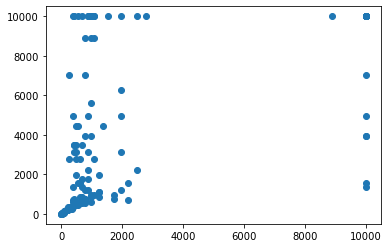

In [33]:
plt.scatter(lambdas, lambdas_norm)

(-0.030317620843328605,
 0.5252532200401585,
 -0.02636684567150921,
 0.5292039952119778)

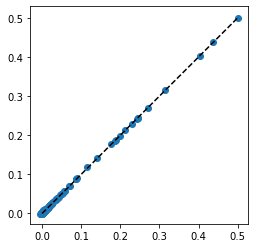

In [42]:
fig, ax = plt.subplots()
ax.scatter(np.max(mean_varexps_lam, axis=1), np.max(mean_varexps_lam_norm, axis=1))
ax.plot([0, 0.5], [0, 0.5], 'k--')
ax.axis('square')

In [212]:
lam_grid = np.geomspace(0.1, 10000, 100)
n_lams = len(lam_grid)
n_cells = traces.shape[1]
varexps = np.zeros((n_cells, n_lams, len(lambda_groups)))
for i, lam in enumerate(lam_grid):
    for j in range(len(lambda_groups)):
        train_inds = np.concatenate([lambda_groups[k] for k in np.setdiff1d(range(len(lambda_groups)), j)])
        test_inds = lambda_groups[j]
        W = fit_glm_gaussian_L2(traces[train_inds,:], X[train_inds,:], lam)
        varexps[:, i, j] = variance_ratio(traces[test_inds,:], W, X[test_inds,:])[1]

In [213]:
varexps[np.isinf(varexps)] = np.nan
mean_varexps = np.nanmean(varexps, axis=2)
lambdas = lam_grid[np.argmax(mean_varexps, axis=1)]

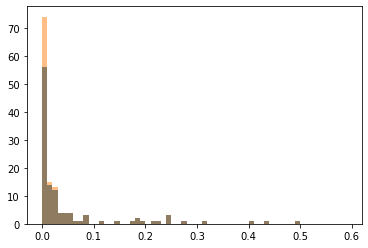

In [36]:
fig, ax = plt.subplots()
ax.hist(np.max(mean_varexps_lam, axis=1), bins=np.arange(0,0.6,0.01));
ax.hist(np.max(mean_varexps_lam_norm, axis=1), bins=np.arange(0,0.6,0.01), alpha=0.5);

In [38]:
mean_varexps_lam.shape

(150, 100)

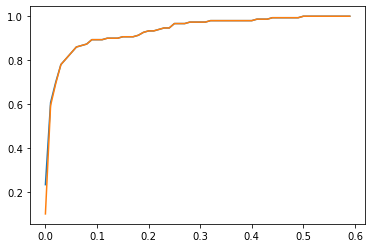

In [40]:
bins = [-1, *np.arange(0,0.6,0.01)]
meanve = np.cumsum(np.histogram(np.max(mean_varexps_lam, axis=1), bins=bins)[0]) / mean_varexps_lam.shape[0]
meanve_norm = np.cumsum(np.histogram(np.max(mean_varexps_lam_norm, axis=1), bins=bins)[0]) / mean_varexps_lam.shape[0]
fig, ax = plt.subplots()
ax.plot(bins[1:], meanve, label='non-normalized');
ax.plot(bins[1:], meanve_norm, label='normalized');


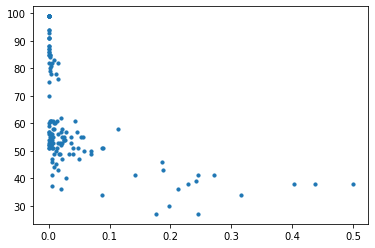

In [30]:
plt.scatter(np.max(mean_varexps_lam, axis=1), np.argmax(mean_varexps_lam, axis=1), s=10)

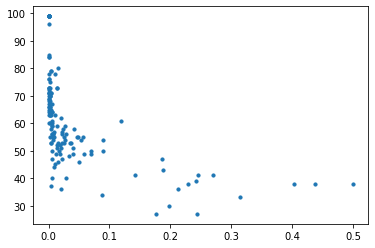

In [31]:
plt.scatter(np.max(mean_varexps_lam_norm, axis=1), np.argmax(mean_varexps_lam_norm, axis=1), s=10)

### hitting the max lambda is OK
- because most of them are bad fits
- Up to about 2000 is reasonable, but keep it as is.

In [216]:
def get_x_y(mouse, plane, session, base_dir):
    roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
    glm_dir = roi_dir / 'glm/touch_combined'
    design_df = pd.read_pickle(glm_dir / 'design.pkl')

    spks = np.load(roi_dir / 'spks_reduced.npy')
    iscell = np.load(roi_dir / 'iscell.npy')
    cell_inds = np.where(iscell[:,0]==1)[0]
    spks = spks[cell_inds,:]
    ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')
    assert len(ophys_frametime) == spks.shape[1]

    # filter out rows from design_df
    # those with NaN values
    # those that are not in ophys_frametime (trialNum, frame_index)
    keep_ind = np.where(np.isnan(np.sum(design_df.values, axis=1).astype(float))==False)[0]
    filtered_design_df = design_df.iloc[keep_ind]
    filtered_design_df = filtered_design_df.query('trialNum in @ophys_frametime.trialNum and frame_index in @ophys_frametime.frame_index')
    filtered_design_df = filtered_design_df.reset_index(drop=True)
    assert len(filtered_design_df.frame_index.unique()) == len(filtered_design_df)
    assert np.isin(filtered_design_df.frame_index.values, ophys_frametime.frame_index.values).all()

    spks_frame_inds = np.where(np.isin(ophys_frametime.frame_index.values, filtered_design_df.frame_index.values))[0]
    assert len(spks_frame_inds) == len(filtered_design_df)
    traces = spks[:,spks_frame_inds].T 
    # Now traces are in shape of (n_frames, n_cells)

    # Standardization
    # No change in touch, lick, reward, sound, num_whisks
    # Just for amplitude and midpoint
    standardized_names = [key for key in filtered_design_df.keys() if ('midpoint' in key) or ('amplitude' in key)]
    for key in standardized_names:
        filtered_design_df[key] = (filtered_design_df[key] - filtered_design_df[key].mean()) / filtered_design_df[key].std()

    # Adding the bias column
    X = np.hstack((np.ones((len(filtered_design_df),1)), filtered_design_df[touch_names + whisking_names + lick_names + sound_names + reward_names].values)).astype(float)

    # Turning into xarray
    x = np.hstack((np.ones((len(filtered_design_df),1)), filtered_design_df[touch_names + whisking_names + lick_names + sound_names + reward_names].values)).astype(float)
    X = xr.DataArray(x, dims=('index', 'feature'), 
                        coords={'index':filtered_design_df.index.values,
                                'feature':['intercept'] + touch_names + whisking_names + lick_names + sound_names + reward_names})
    traces = xr.DataArray(traces, dims=('index', 'cell_id'),
                        coords={'index':filtered_design_df.index.values,
                                'cell_id':cell_inds})
    return X, traces, filtered_design_df

In [217]:
X, traces, filtered_design_df = get_x_y(mouse, plane, session, base_dir)
lambda_groups, fit_groups = get_stratified_frame_indice(mouse, plane, session, base_dir, filtered_design_df)
lambdas, mean_varexps_lambda_search = find_lambda(traces, X, lambda_groups)

In [344]:
ci = 1
xx=X.isel(index=train_inds)
tt = traces.isel(index=train_inds,cell_id=ci)
w = np.dot(np.linalg.inv(np.dot(xx.T, xx) + lam * np.eye(xx.shape[-1])),
               np.dot(xx.T, tt.values))

In [345]:
if len(w.shape) == 1:
    w = w[:,np.newaxis]
w.shape

(58, 1)

In [353]:
len(tt.cell_id.values.shape)

0

In [362]:
if len(tt.cell_id.values.shape)==0:
    cell_id = np.array([int(tt.cell_id.values)])
else:
    cell_id = tt.cell_id.values

In [247]:
# fitting with cell-specific lambda
predicted_fold = np.zeros(traces.shape)
varexp_model_fold = np.zeros((traces.shape[1], len(fit_groups)))
W_all = xr.DataArray(np.zeros((X.shape[-1], traces.shape[1], len(fit_groups))),
                            dims=('feature', 'cell_id', 'fold'),
                            coords={'feature': X.feature.values,
                                    'cell_id': traces.cell_id.values,
                                    'fold': [f'fold_{i}' for i in np.arange(len(fit_groups))]})
for fi in range(len(fit_groups)):
    train_inds = np.concatenate([fit_groups[k] for k in np.setdiff1d(range(len(fit_groups)), fi)])
    test_inds = fit_groups[fi]
    for ci in range(traces.shape[1]):
        lam = lambdas[ci]
        W_temp = fit_glm_gaussian_L2(traces.isel(index=train_inds,cell_id=ci), X.isel(index=train_inds), lam)
        W_all[:,ci,fi] = W_temp.squeeze()
        pred, ve = variance_ratio(traces.isel(index=test_inds,cell_id=ci), W_temp, X.isel(index=test_inds))
        predicted_fold[test_inds,ci] = pred.reshape((len(test_inds),))
        varexp_model_fold[ci, fi] = ve

# adding final model of a cell
W_final = W_all.mean(dim='fold')
pred_final, ve_final = variance_ratio(traces, W_final, X)
    

In [254]:
def fit_model(X, traces, fit_groups, lambdas):
    ''' Fitting the model with cell-specific lambda
    X: xarray (n_frames x n_features)
    traces: xarray (n_frames, n_cells)
    fit_groups: list of indices for cross-validation
    lambdas: 1d array of lambda values

        Returns:
        predicted_final: xarray (n_frames, n_cells)
        ve_model_final: xarray (n_cells)
        W_final: xarray (n_features, n_cells)
        predicted_fold: xarray (n_frames, n_cells)
        varexp_fold: xarray (n_cells, n_folds)
        W_all: xarray (n_features, n_cells, n_folds)
    '''
    predicted_fold = np.zeros(traces.shape)
    varexp_fold = np.zeros((traces.shape[1], len(fit_groups)))
    W_all = xr.DataArray(np.zeros((X.shape[-1], traces.shape[1], len(fit_groups))),
                            dims=('feature', 'cell_id', 'fold'),
                            coords={'feature': X.feature.values,
                                    'cell_id': traces.cell_id.values,
                                    'fold': [f'fold_{i}' for i in np.arange(len(fit_groups))]})
    for fi in range(len(fit_groups)):
        train_inds = np.concatenate([fit_groups[k] for k in np.setdiff1d(range(len(fit_groups)), fi)])
        test_inds = fit_groups[fi]
        for ci in range(traces.shape[1]):
            lam = lambdas[ci]
            W_temp = fit_glm_gaussian_L2(traces.isel(index=train_inds,cell_id=ci), X.isel(index=train_inds), lam)
            W_all[:,ci,fi] = W_temp.squeeze()
            pred, ve = variance_ratio(traces.isel(index=test_inds,cell_id=ci), W_temp, X.isel(index=test_inds))
            predicted_fold[test_inds,ci] = pred.reshape((len(test_inds),))
            varexp_fold[ci, fi] = ve
    varexp_fold = xr.DataArray(varexp_fold,
                                dims=('cell_id', 'fold'),
                                coords={'cell_id':traces.cell_id.values,
                                        'fold': [f'fold_{i}' for i in np.arange(len(fit_groups))]})
    predicted_fold = xr.DataArray(predicted_fold, dims=('index', 'cell_id'),
                             coords={'index':traces.index.values,
                                     'cell_id':traces.cell_id.values})
    
    # adding final model of a cell  
    W_final = W_all.mean(dim='fold')
    pred_final, ve_final = variance_ratio(traces, W_final, X)
    predicted_final = xr.DataArray(pred_final, dims=('index', 'cell_id'),
                             coords={'index':traces.index.values,
                                     'cell_id':traces.cell_id.values})
    ve_final = xr.DataArray(ve_final, dims=('cell_id'),
                             coords={'cell_id':traces.cell_id.values})

    return predicted_final, ve_final, W_final, predicted_fold, varexp_fold, W_all

In [294]:
predicted_final, ve_model_final, W_final, predicted_fold, varexp_model_fold, W_fold = fit_model(X, traces, fit_groups, lambdas)

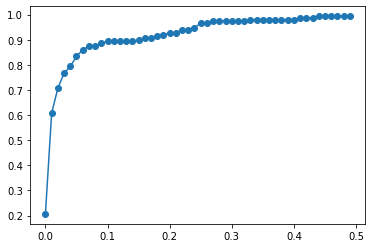

In [251]:
bins = [-100, *np.arange(0,0.5,0.01), 1]
mean_ve = np.mean(varexp_model_fold, axis=1)
ve_dist = np.histogram(mean_ve, bins=bins)[0]
ve_cumdist = np.cumsum(ve_dist) / len(mean_ve)
fig, ax = plt.subplots()
ax.plot(bins[1:-1], ve_cumdist[:-1], marker='o')


Text(0, 0.5, 'Final variance explained')

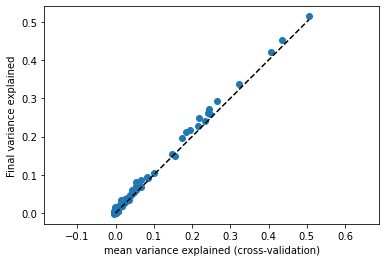

In [253]:
fig, ax = plt.subplots()
ax.scatter(mean_ve, ve_model_final)
ax.axis('equal')
ax.plot([0, np.max(mean_ve)], [0, np.max(mean_ve)], 'k--')
ax.set_xlabel('mean variance explained (cross-validation)')
ax.set_ylabel('Final variance explained')


In [287]:
# dropping each features and calculating the reduction in variance explained
# run finding lambda as well
touch_names = [key for key in filtered_design_df.keys() if 'touch_count' in key]
whisking_names = [key for key in filtered_design_df.keys() if ('num_whisks' in key) or ('midpoint' in key) or ('amplitude' in key)]
lick_names = [key for key in filtered_design_df.keys() if 'num_lick' in key]
sound_names = [key for key in filtered_design_df.keys() if 'pole_in_frame' in key or 'pole_out_frame' in key]
reward_names = [key for key in filtered_design_df.keys() if 'first_reward_lick' in key]
feature_names = {'touch': touch_names,
                 'whisking': whisking_names,
                 'lick': lick_names,
                 'sound': sound_names,
                 'reward': reward_names}

def drop_feature_and_fit(X, traces, lambda_groups, fit_groups, feature_names):
    '''Drop each features and fit the model
    Re-run finding lambda as well
    '''
    n_cells = traces.shape[1]
    n_features = len(feature_names)
    varexp_drop = xr.DataArray(np.zeros((n_cells, n_features)),
							dims=('cell_id', 'dropped_feature'),
							coords={'cell_id':traces.cell_id.values,
									'dropped_feature': list(feature_names.keys())})
    predicted_drop = xr.DataArray(np.zeros((*traces.shape, n_features)),
									dims=('index', 'cell_id', 'dropped_feature'),
									coords={'index':traces.index.values,
											'cell_id':traces.cell_id.values,
											'dropped_feature': list(feature_names.keys())})
    W_drop = xr.DataArray(np.zeros((X.shape[-1], n_cells, n_features)),
							dims=('feature', 'cell_id', 'dropped_feature'),
							coords={'feature': X.feature.values,
									'cell_id':traces.cell_id.values,
									'dropped_feature': list(feature_names.keys())})
    lambdas_drop = xr.DataArray(np.zeros((n_cells, n_features)),
							dims=('cell_id', 'dropped_feature'),
							coords={'cell_id':traces.cell_id.values,
									'dropped_feature': list(feature_names.keys())})
    for fni, key in enumerate(feature_names.keys()):
        X_temp = X.sel(feature=np.setdiff1d(X.feature.values, feature_names[key]))
        lam_d, _ = find_lambda(traces, X_temp, lambda_groups)
        pred_d, ve_d, W_d, _, _, _ = fit_model(X_temp, traces, fit_groups, lam_d)
        varexp_drop[:,fni] = ve_d
        predicted_drop[:,:,fni] = pred_d
        matching_indices = {'feature': W_d['feature'], 'cell_id': W_d['cell_id'], 'dropped_feature': key}
        W_drop.loc[matching_indices] = W_d
        lambdas_drop[:,fni] = lam_d

    varexp_drop = xr.DataArray(varexp_drop,
                            dims=('cell_id', 'dropped_feature'),
                            coords={'cell_id':traces.cell_id.values,
                                    'dropped_feature': list(feature_names.keys())})
    predicted_drop = xr.DataArray(predicted_drop,
                                    dims=('index', 'cell_id', 'dropped_feature'),
                                    coords={'index':traces.index.values,
                                            'cell_id':traces.cell_id.values,
                                            'dropped_feature': list(feature_names.keys())})
    W_drop = xr.DataArray(W_drop,
                            dims=('feature', 'cell_id', 'dropped_feature'),
                            coords={'feature': X.feature.values,
                                    'cell_id':traces.cell_id.values,
                                    'dropped_feature': list(feature_names.keys())})
    lambdas_drop = xr.DataArray(lambdas_drop,
                            dims=('cell_id', 'dropped_feature'),
                            coords={'cell_id':traces.cell_id.values,
                                    'dropped_feature': list(feature_names.keys())})
    return varexp_drop, predicted_drop, W_drop, lambdas_drop


In [280]:
n_cells = traces.shape[1]
n_features = len(feature_names)
varexp_drop = xr.DataArray(np.zeros((n_cells, n_features)),
                            dims=('cell_id', 'dropped_feature'),
                            coords={'cell_id':traces.cell_id.values,
                                    'dropped_feature': list(feature_names.keys())})
predicted_drop = xr.DataArray(np.zeros((*traces.shape, n_features)),
                                dims=('index', 'cell_id', 'dropped_feature'),
                                coords={'index':traces.index.values,
                                        'cell_id':traces.cell_id.values,
                                        'dropped_feature': list(feature_names.keys())})
W_drop = xr.DataArray(np.zeros((X.shape[-1], n_cells, n_features)),
                        dims=('feature', 'cell_id', 'dropped_feature'),
                        coords={'feature': X.feature.values,
                                'cell_id':traces.cell_id.values,
                                'dropped_feature': list(feature_names.keys())})
lambdas_drop = xr.DataArray(np.zeros((n_cells, n_features)),
                            dims=('cell_id', 'dropped_feature'),
                            coords={'cell_id':traces.cell_id.values,
                                    'dropped_feature': list(feature_names.keys())})
for fni, key in enumerate(feature_names.keys()):
    X_temp = X.sel(feature=np.setdiff1d(X.feature.values, feature_names[key]))
    lam_d, _ = find_lambda(traces, X_temp, lambda_groups)
    pred_d, ve_d, W_d, _, _, _ = fit_model(X_temp, traces, fit_groups, lam_d)
    varexp_drop[:,fni] = ve_d
    predicted_drop[:,:,fni] = pred_d
    matching_indices = {'feature': W_d['feature'], 'cell_id': W_d['cell_id'], 'dropped_feature': key}
    W_drop.loc[matching_indices] = W_d
    lambdas_drop[:,fni] = lam_d

varexp_drop = xr.DataArray(varexp_drop,
                            dims=('cell_id', 'dropped_feature'),
                            coords={'cell_id':traces.cell_id.values,
                                    'dropped_feature': list(feature_names.keys())})
predicted_drop = xr.DataArray(predicted_drop,
                                dims=('index', 'cell_id', 'dropped_feature'),
                                coords={'index':traces.index.values,
                                        'cell_id':traces.cell_id.values,
                                        'dropped_feature': list(feature_names.keys())})
W_drop = xr.DataArray(W_drop,
                        dims=('feature', 'cell_id', 'dropped_feature'),
                        coords={'feature': X.feature.values,
                                'cell_id':traces.cell_id.values,
                                'dropped_feature': list(feature_names.keys())})
lambdas_drop = xr.DataArray(lambdas_drop,
                            dims=('cell_id', 'dropped_feature'),
                            coords={'cell_id':traces.cell_id.values,
                                    'dropped_feature': list(feature_names.keys())})

In [289]:
varexp_drop, predicted_drop, W_drop, lambdas_drop = drop_feature_and_fit(X, traces, lambda_groups, fit_groups, feature_names)

Text(0.5, 1.0, '030 plane 2 session 012')

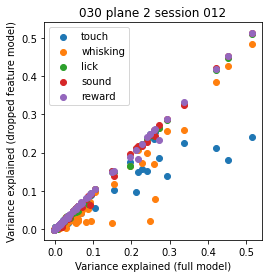

In [292]:
fig, ax = plt.subplots()
for feature in varexp_drop.dropped_feature.values:
    ax.scatter(ve_model_final, varexp_drop.sel(dropped_feature=feature), label=feature)
ax.axis('square')
ax.set_xlabel('Variance explained (full model)')
ax.set_ylabel('Variance explained (dropped feature model)')
ax.legend()
ax.set_title(f'{mouse:03} plane {plane} session {session:03}')

In [295]:
dataset = xr.Dataset({'traces': traces,
                      'X': X,
                      'varexp_model_final': ve_model_final,
                      'predicted_final': predicted_final,
                      'W_final': W_final,
                      'predicted_fold': predicted_fold,
                      'varexp_model_fold': varexp_model_fold,
                      'W_fold': W_fold,
                      'lambdas': lambdas,
                      'varexp_drop': varexp_drop,
                      'predicted_drop': predicted_drop,
                      'W_drop': W_drop,
                      'lambdas_drop': lambdas_drop,})
dataset.to_netcdf(glm_dir / 'glm_result.nc')
split = {'lambda_groups': lambda_groups,
         'fit_groups': fit_groups}
np.save(glm_dir / 'glm_split.npy', split)

# Run in parallel
- scripts\fit_glm_touch_combined_par.py
    - using scripts\fit_glm.py
- with 18 cores, about an hour is expected.
    - It took about 10 hrs.

# Look at the performance

In [45]:
glm_result.keys()

KeysView(<xarray.Dataset>
Dimensions:             (index: 4106, cell_id: 120, dropped_feature: 5,
                         feature: 58, fold: 5, lambdas: 120)
Coordinates:
  * index               (index) int32 0 1 2 3 4 5 ... 4101 4102 4103 4104 4105
  * cell_id             (cell_id) int32 0 1 2 4 5 7 ... 140 141 142 143 144 145
  * lambdas             (lambdas) float64 432.9 14.85 ... 7.055e+03 7.055e+03
  * feature             (feature) object 'intercept' ... 'first_reward_lick_r...
  * dropped_feature     (dropped_feature) object 'touch' 'whisking' ... 'reward'
  * fold                (fold) object 'fold_0' 'fold_1' ... 'fold_3' 'fold_4'
Data variables:
    predicted_drop      (index, cell_id, dropped_feature) float64 ...
    traces              (index, cell_id) float32 ...
    predicted_final     (index, cell_id) float64 ...
    predicted_fold      (index, cell_id) float64 ...
    X                   (index, feature) float64 ...
    varexp_model_fold   (cell_id, fold) float64 ...
 

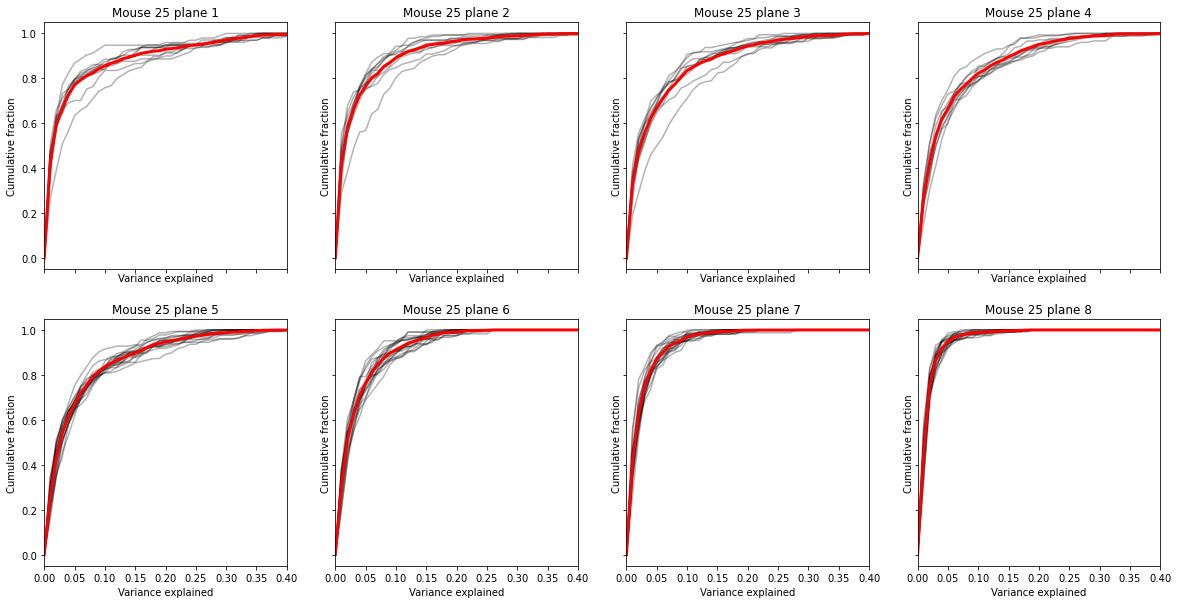

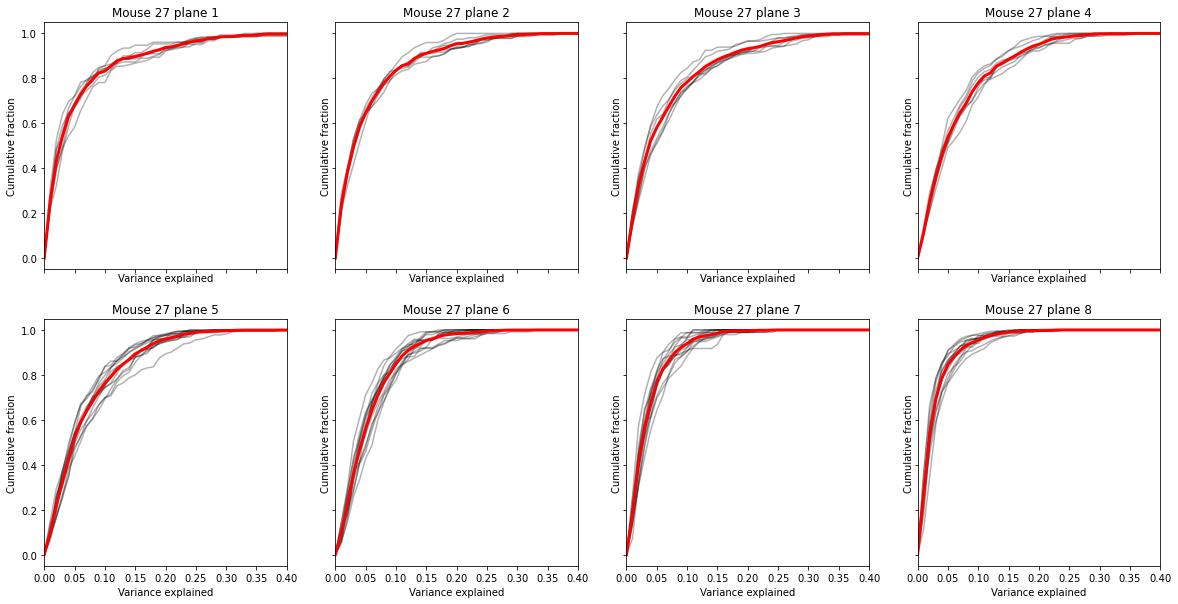

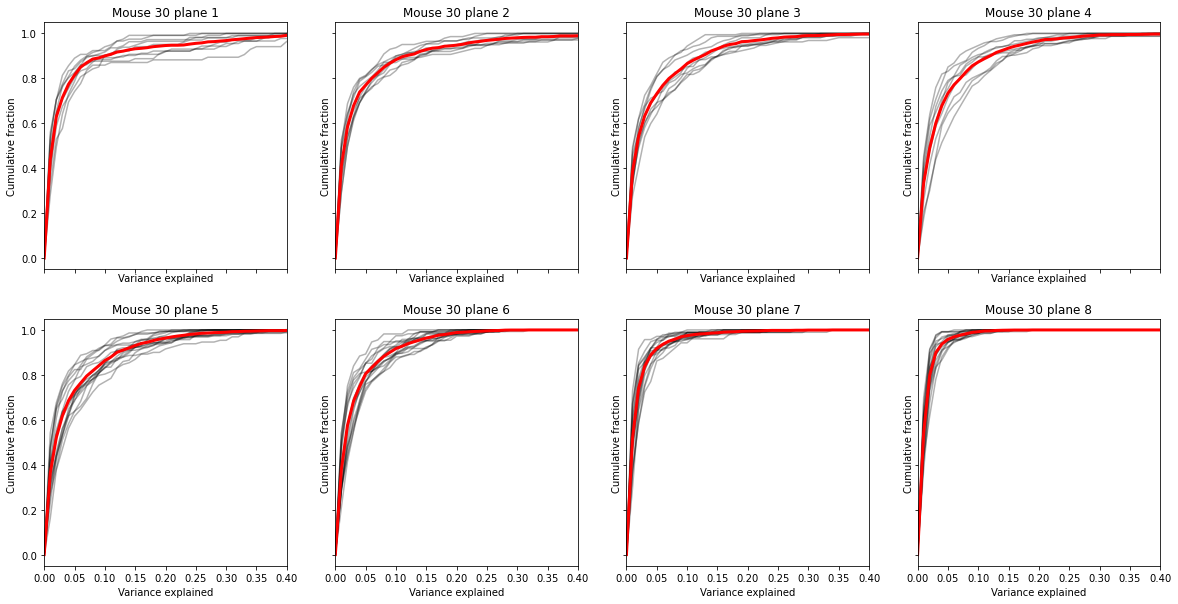

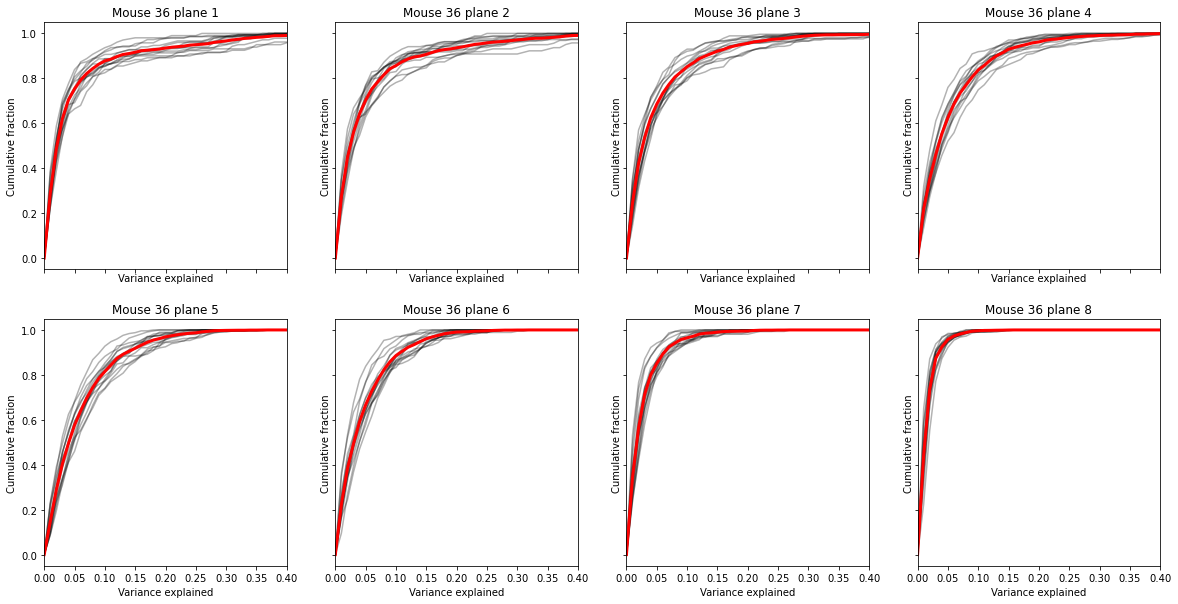

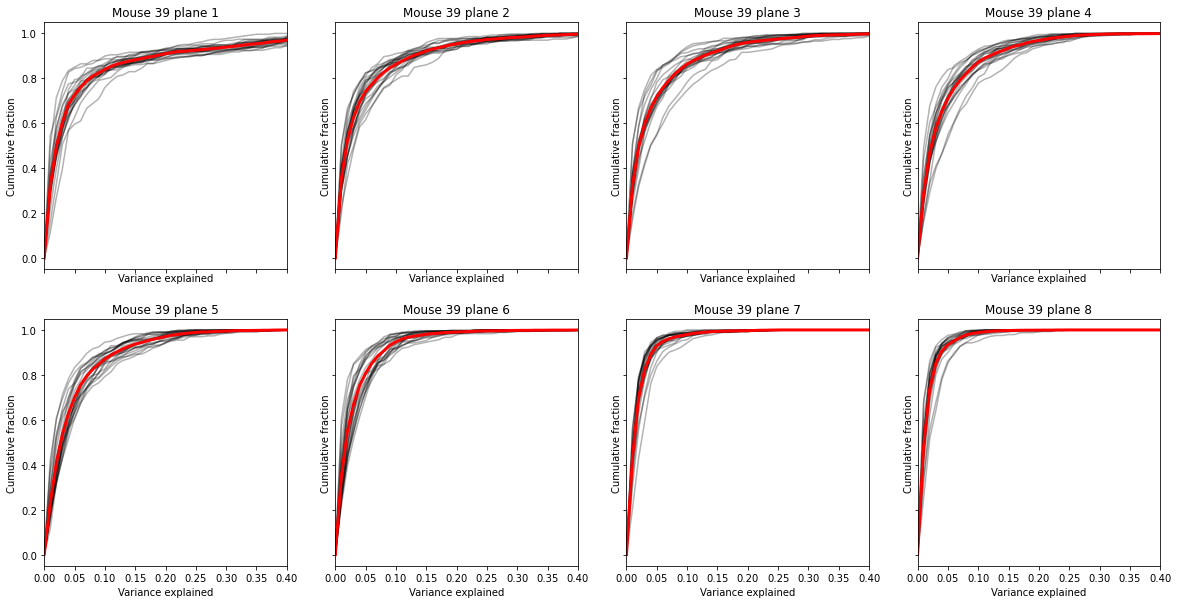

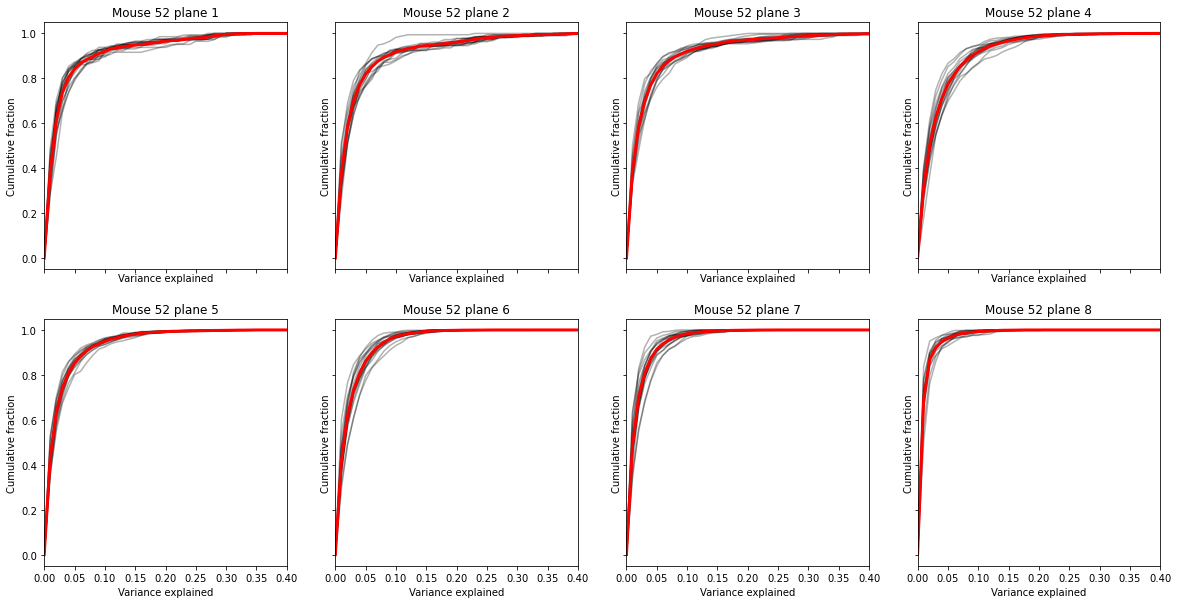

In [48]:
bins = [-1, *np.arange(0,0.6,0.01), 1]
mice = use_mice_df.mouse.unique()
for mouse in mice:
    fig, axs = plt.subplots(2,4, figsize=(20,10), sharex=True, sharey=True)
    for plane in range(1,9):
        ax = axs.flatten()[plane-1]
        sessions = use_mice_df.query('mouse == @mouse and plane == @plane').session.unique().astype(int)

        ve_cumdist = np.zeros((len(sessions), len(bins)-2))
        for si, session in enumerate(sessions):
            roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
            glm_dir = roi_dir / 'glm/touch_combined'
            glm_result = xr.open_dataset(glm_dir / 'glm_result.nc')
            varexp_model_final = glm_result['varexp_model_final']
            cumhist = np.cumsum(np.histogram(varexp_model_final, bins=bins)[0])/varexp_model_final.shape[0]
            ve_cumdist[si] = cumhist[:-1]
        for cumhist in ve_cumdist:
            ax.plot(bins[1:-1], cumhist, 'k-', alpha=0.3)
        ax.plot(bins[1:-1], ve_cumdist.mean(axis=0), 'r-', lw=3)
        ax.set_xlabel('Variance explained')
        ax.set_ylabel('Cumulative fraction')
        ax.set_title(f'Mouse {mouse} plane {plane}')
        ax.set_xlim([0,0.4])

In [50]:
mouse = 25
plane = 1
sessions = use_mice_df.query('mouse == @mouse and plane == @plane').session.unique().astype(int)
session = sessions[0]
roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
glm_dir = roi_dir / 'glm/touch_combined'
glm_result = xr.open_dataset(glm_dir / 'glm_result.nc')
varexp_model = glm_result['varexp_model_fold']

from scipy.stats import t
def ttest_pval(x):
    tval = x.mean() / (x.std() / np.sqrt(len(x)))
    pval = t.sf(np.abs(tval), len(x)-1)*2
    return pval

pvals = np.zeros(varexp_model.shape[0])
for i in range(varexp_model.shape[0]):
    pvals[i] = ttest_pval(varexp_model.isel(cell_id=i).values)
    

Text(0.5, 1.0, 'Mouse 25 plane 1 session 001')

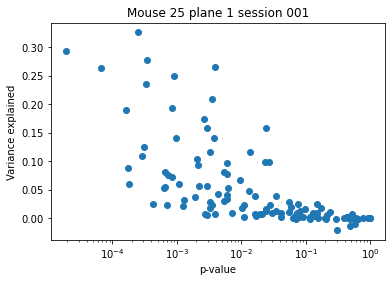

In [51]:
fig, ax = plt.subplots()
ax.scatter(pvals, varexp_model.mean(dim='fold', skipna=True))
ax.set_xscale('log')
ax.set_xlabel('p-value')
ax.set_ylabel('Variance explained')
ax.set_title(f'Mouse {mouse} plane {plane} session {session:03}')

In [52]:
mouse = 25
plane = 1
p_bins = [0, *np.geomspace(1e-5, 1, 50)]
thresholds = [0.02, 0.05, 0.1]
sessions = use_mice_df.query('mouse == @mouse and plane == @plane').session.unique().astype(int)
hist_pvals = np.zeros((len(sessions), len(thresholds), len(p_bins)-1))
for si, session in enumerate(sessions):
    roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
    glm_dir = roi_dir / 'glm/touch_combined'
    glm_result = xr.open_dataset(glm_dir / 'glm_result.nc')
    varexp_model = glm_result['varexp_model_fold']
    mean_ve = varexp_model.mean(dim='fold', skipna=True)
    pvals = np.zeros(varexp_model.shape[0])
    for ci in range(varexp_model.shape[0]):
        pvals[ci] = ttest_pval(varexp_model.isel(cell_id=ci).values)
        # dist of pvals > threshold
        for ti, threshold in enumerate(thresholds):
            above_threshold_inds = np.where(mean_ve >= threshold)[0]
            hist_pvals[si,ti,:] = np.histogram(pvals[above_threshold_inds], bins=p_bins,
                                               )[0]/len(above_threshold_inds)

Text(0.5, 1.0, 'Mouse 25 plane 1')

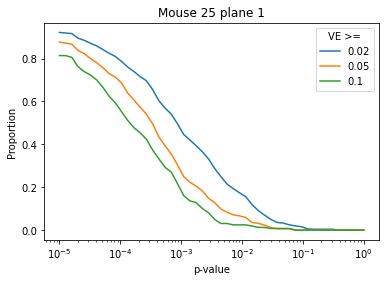

In [53]:
fig, ax = plt.subplots()
for ti, threshold in enumerate(thresholds):
    cum_hist = np.cumsum(hist_pvals.mean(axis=0)[ti])
    ax.plot(p_bins[1:], 1-cum_hist, label=f'{threshold}')
ax.set_xscale('log')
ax.set_xlabel('p-value')
ax.set_ylabel('Proportion')
ax.legend(title='VE >=')
ax.set_title(f'Mouse {mouse} plane {plane}')

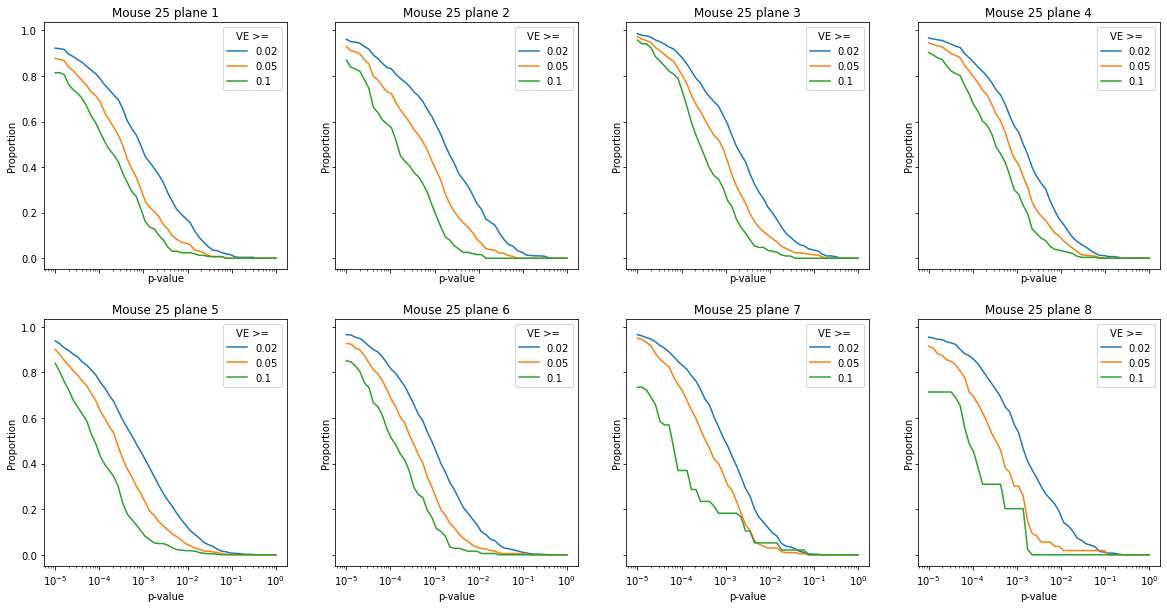

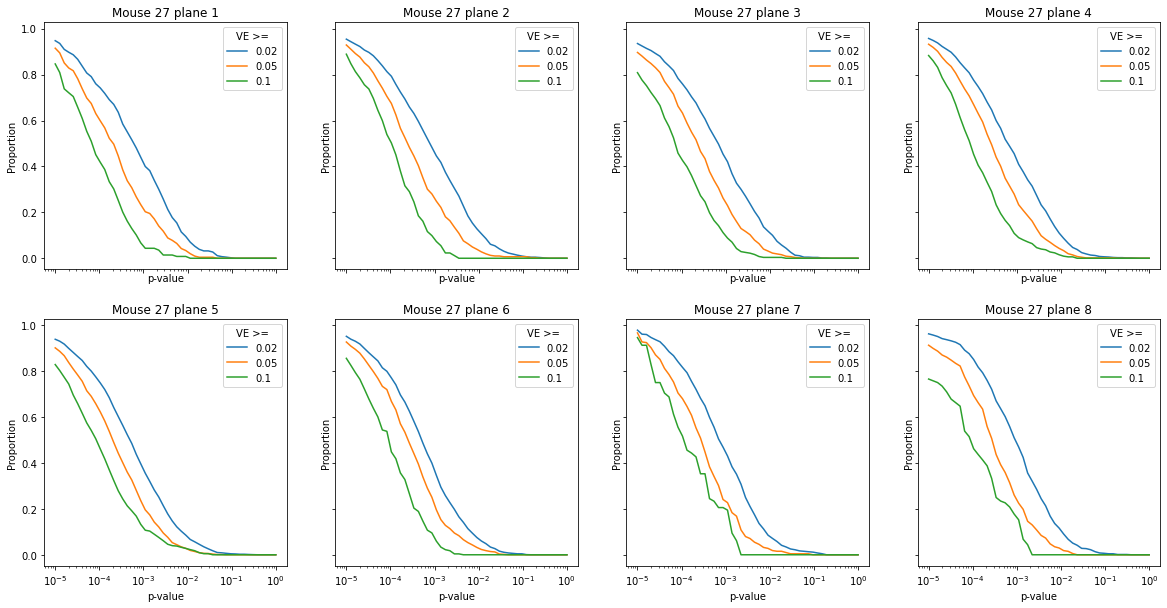

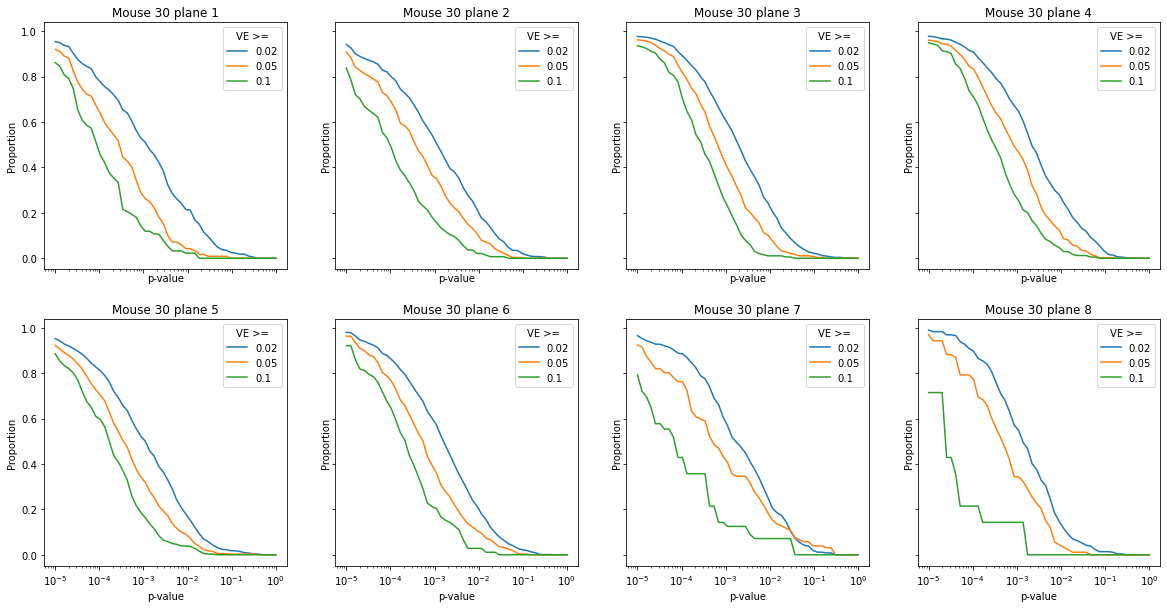

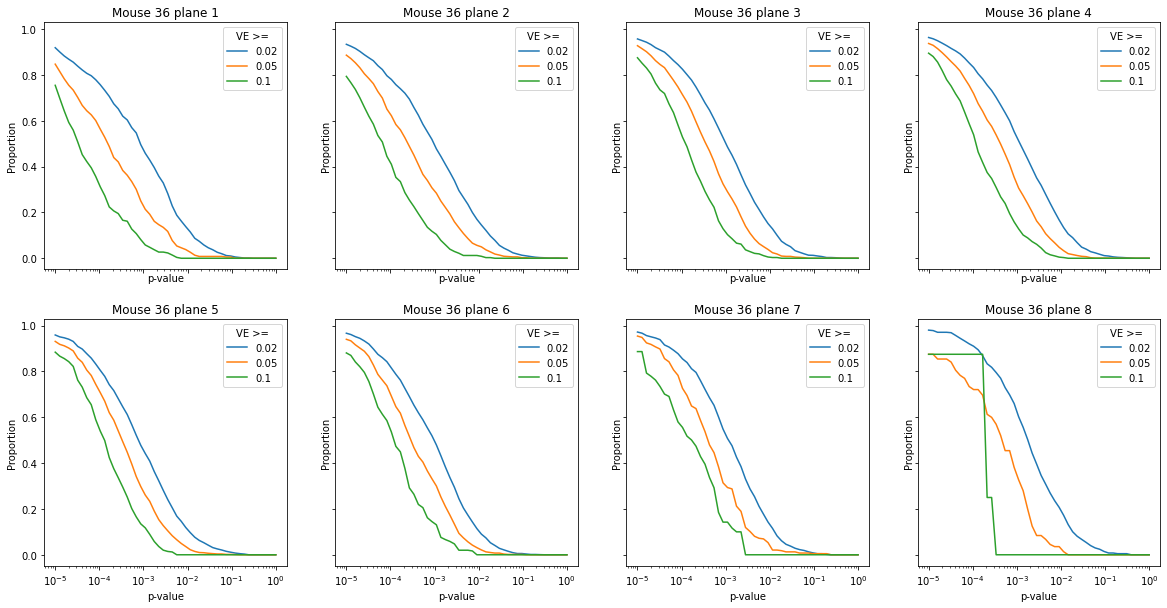

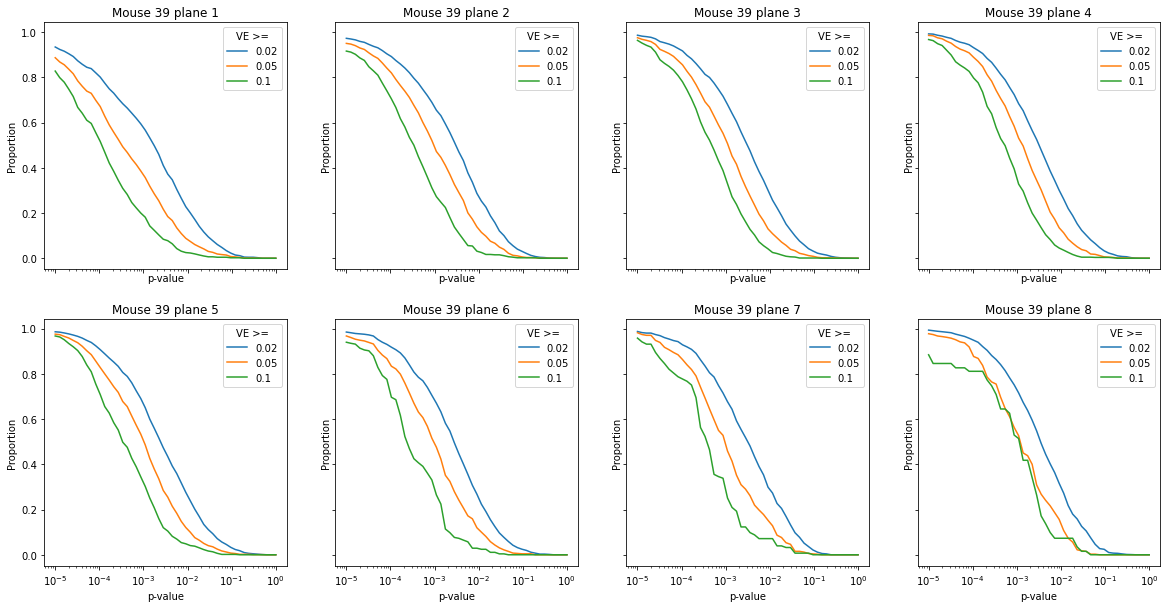

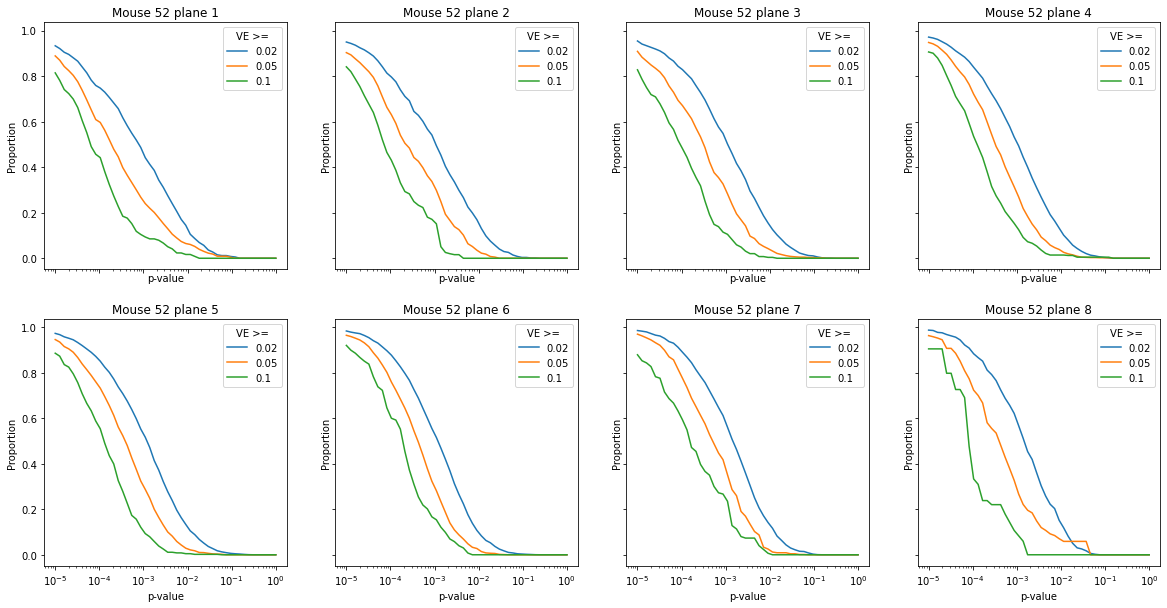

In [54]:
p_bins = [0, *np.geomspace(1e-5, 1, 50)]
thresholds = [0.02, 0.05, 0.1]
mice = use_mice_df.mouse.unique()
for mouse in mice:
    fig, axs = plt.subplots(2,4, figsize=(20,10), sharex=True, sharey=True)
    for plane in range(1,9):
        ax = axs.flatten()[plane-1]
        sessions = use_mice_df.query('mouse == @mouse and plane == @plane').session.unique().astype(int)
        hist_pvals = np.zeros((len(sessions), len(thresholds), len(p_bins)-1))
        for si, session in enumerate(sessions):
            roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
            glm_dir = roi_dir / 'glm/touch_combined'
            glm_result = xr.open_dataset(glm_dir / 'glm_result.nc')
            varexp_model = glm_result['varexp_model_fold']
            mean_ve = varexp_model.mean(dim='fold', skipna=True)
            pvals = np.zeros(varexp_model.shape[0])
            for ci in range(varexp_model.shape[0]):
                pvals[ci] = ttest_pval(varexp_model.isel(cell_id=ci).values)
                # dist of pvals > threshold
                for ti, threshold in enumerate(thresholds):
                    above_threshold_inds = np.where(mean_ve >= threshold)[0]
                    if len(above_threshold_inds) > 0:
                        hist_pvals[si,ti,:] = np.histogram(pvals[above_threshold_inds],
                                                           bins=p_bins,
                                                           )[0]/len(above_threshold_inds)
                    else:
                        hist_pvals[si,ti,:] = np.nan
        for ti, threshold in enumerate(thresholds):
            cum_hist = np.cumsum(np.nanmean(hist_pvals, axis=0)[ti])
            ax.plot(p_bins[1:], 1-cum_hist, label=f'{threshold}')
        ax.set_xscale('log')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Proportion')
        ax.legend(title='VE >=')
        ax.set_title(f'Mouse {mouse} plane {plane}')

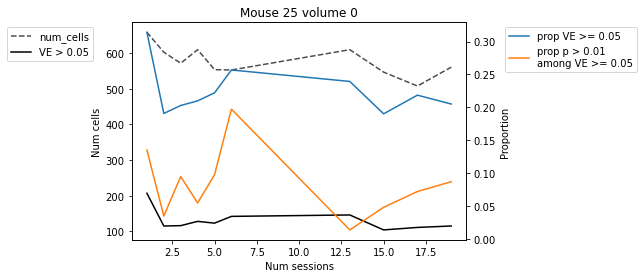

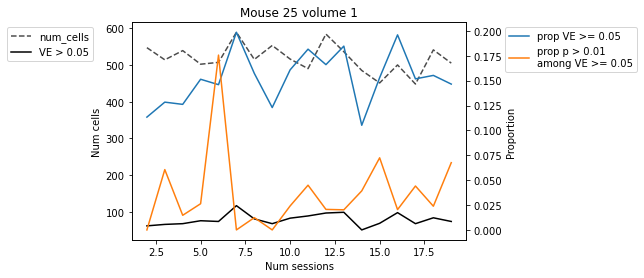

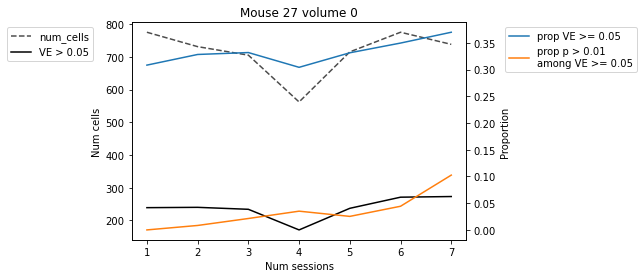

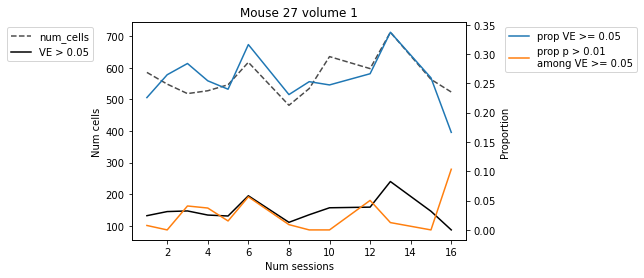

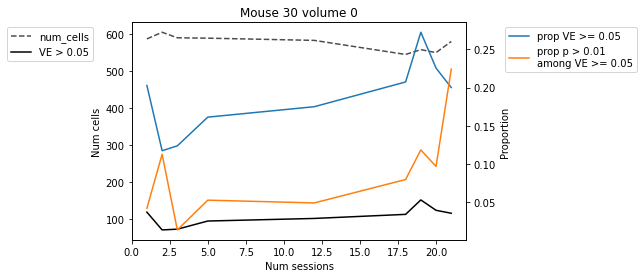

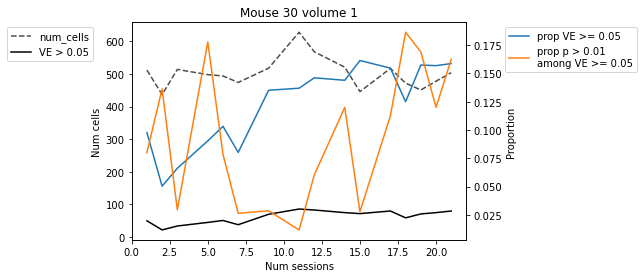

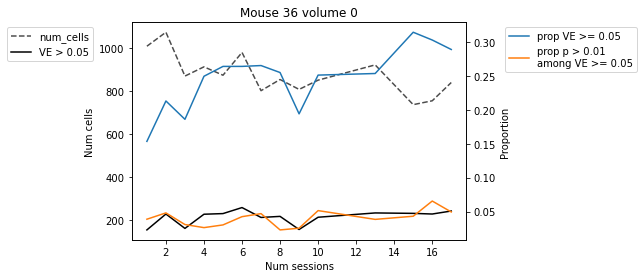

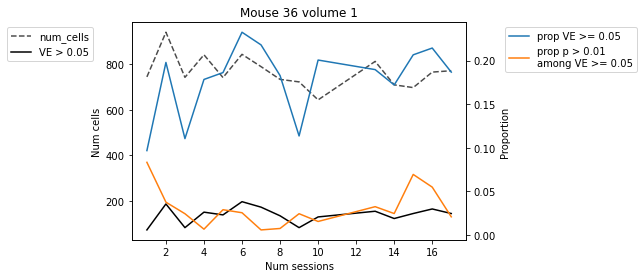

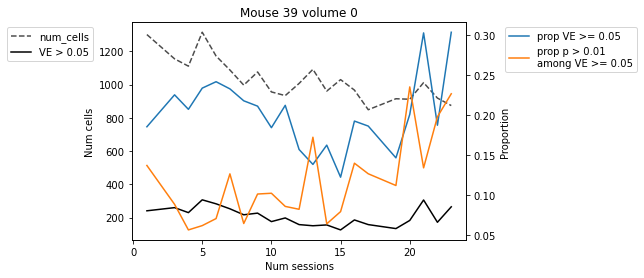

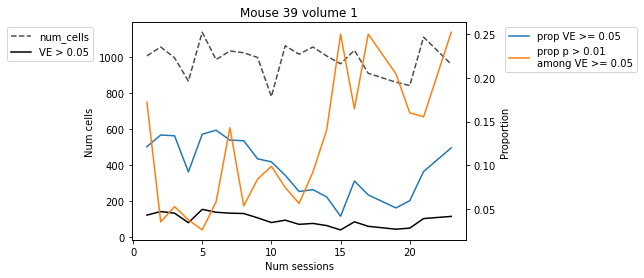

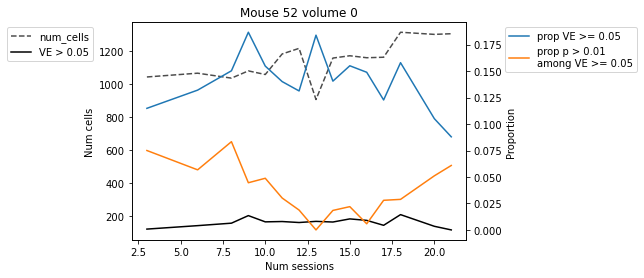

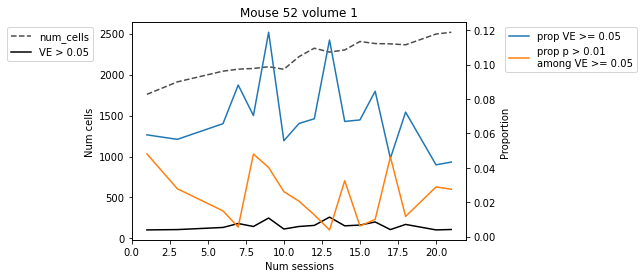

In [56]:
# summary stats
# Based on 0.05 as significant VarExp threshold
# How many cells are VE >= 0.05? What is the percentage?
# what is the proportion p > 0.01 for these cells?
# All in volume-wise
mice = use_mice_df.mouse.unique()
ve_threshold = 0.05
p_threshold = 0.01
for mouse in mice:
    for volume in range(2):
        if volume == 0:
            planes = np.arange(1,5)
        else:
            planes = np.arange(5,9)
        top_plane = planes[0]
        sessions = use_mice_df.query('mouse == @mouse and plane == @top_plane').session.unique().astype(int)
        num_cells = np.zeros((len(sessions), len(planes)))
        num_ve_threshold = np.zeros((len(sessions), len(planes)))
        num_p_threshold = np.zeros((len(sessions), len(planes)))
        for si, session in enumerate(sessions):
            for pi, plane in enumerate(planes):
                roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
                glm_dir = roi_dir / 'glm/touch_combined'
                glm_result = xr.open_dataset(glm_dir / 'glm_result.nc')
                varexp_model = glm_result['varexp_model_fold']
                mean_ve = varexp_model.mean(dim='fold', skipna=True)
                pvals = np.zeros(varexp_model.shape[0])
                for ci in range(varexp_model.shape[0]):
                    pvals[ci] = ttest_pval(varexp_model.isel(cell_id=ci).values)
                num_cells[si,pi] = len(mean_ve)
                num_ve_threshold[si,pi] = np.sum(mean_ve >= ve_threshold)
                num_p_threshold[si,pi] = np.sum(pvals[np.where(mean_ve >= ve_threshold)] > p_threshold)
        fig, ax = plt.subplots()
        ax.plot(sessions, num_cells.sum(axis=1), 'k--', alpha=0.7, label='num_cells')
        ax.plot(sessions, num_ve_threshold.sum(axis=1), 'k-', label='VE > 0.05')
        axx = ax.twinx()
        axx.plot(sessions, num_ve_threshold.sum(axis=1) / num_cells.sum(axis=1),
                 label=f'prop VE >= {ve_threshold}',
                 color='C0')
        axx.plot(sessions, num_p_threshold.sum(axis=1) / num_ve_threshold.sum(axis=1),
                 label=f'prop p > {p_threshold}\namong VE >= {ve_threshold}',
                 color='C1')
        ax.set_xlabel('Num sessions')
        ax.set_ylabel('Num cells')
        axx.set_ylabel('Proportion')
        ax.legend(loc='upper right', bbox_to_anchor=(-0.1,1))
        axx.legend(loc='upper left', bbox_to_anchor=(1.1,1))
        ax.set_title(f'Mouse {mouse} volume {volume}')



In [58]:
# Nosystematic bis in sessions
# Aggregate the sessions (take the mean)
mice = use_mice_df.mouse.unique()
ve_threshold = 0.05
p_threshold = 0.01
prop_ve = np.zeros((len(mice), 2))
prop_p = np.zeros((len(mice), 2))
for mi, mouse in enumerate(mice):
    for volume in range(2):
        if volume == 0:
            planes = np.arange(1,5)
        else:
            planes = np.arange(5,9)
        top_plane = planes[0]
        sessions = use_mice_df.query('mouse == @mouse and plane == @top_plane').session.unique().astype(int)
        num_cells = np.zeros((len(sessions), len(planes)))
        num_ve_threshold = np.zeros((len(sessions), len(planes)))
        num_p_threshold = np.zeros((len(sessions), len(planes)))
        for si, session in enumerate(sessions):
            for pi, plane in enumerate(planes):
                roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
                glm_dir = roi_dir / 'glm/touch_combined'
                glm_result = xr.open_dataset(glm_dir / 'glm_result.nc')
                varexp_model = glm_result['varexp_model_fold']
                mean_ve = varexp_model.mean(dim='fold', skipna=True)
                pvals = np.zeros(varexp_model.shape[0])
                for ci in range(varexp_model.shape[0]):
                    pvals[ci] = ttest_pval(varexp_model.isel(cell_id=ci).values)
                num_cells[si,pi] = len(mean_ve)
                num_ve_threshold[si,pi] = np.sum(mean_ve >= ve_threshold)
                num_p_threshold[si,pi] = np.sum(pvals[np.where(mean_ve >= ve_threshold)] > p_threshold)
        prop_ve[mi, volume] = num_ve_threshold.sum() / num_cells.sum()
        prop_p[mi, volume] = num_p_threshold.sum() / num_ve_threshold.sum()

In [60]:
print(f'VE >= {ve_threshold}: {np.mean(prop_ve)} +/- {np.std(prop_ve)}')
print(f'p <= {p_threshold} among VE >= {ve_threshold}: {1-np.mean(prop_p)} +/- {np.std(prop_p)}')

VE >= 0.05: 0.18455146301905756 +/- 0.07124774846598783
p <= 0.01 among VE >= 0.05: 0.939776408210983 +/- 0.034578561825483585


## Just a check for multiprocessing
- numpy linalg uses multiprocessing in the backend.
- Using multiprocessing on top of it might make weird calculation.
- Most likely not, but just to make sure...
- Test in one session where expert test session had lower angle separation than the naive test session.

In [ ]:
mouse = 52
plane = 5
session = 

# Touch GLM before and after touch divided
-"touch_divided"
- Either ignore miss trials, or include miss, touch_before_answer, and touch_after_answer.

### Deal with no-answer trials
- There could be licks before the answer period, without answer lick
    - How often does it happen?
- How should I assign touches without the answer lick?
    - Assign it separately (no-answer touch)
    - Assign as "before answer" touch


In [128]:
mouse = 25
plane = 1
sessions = use_mice_df.query('mouse == @mouse and plane == @plane').session.unique().astype(int)
session = sessions[0]

plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_fn = plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl'

behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
catch_trial_nums = behavior_frametime.query('trial_type == "oo"')['trialNum'].unique()
merbehavior_frametimeged_df = behavior_frametime.query('trialNum not in @catch_trial_nums')
behavior_frametime.columns


Index(['trialNum', 'frame_start_time', 'frame_end_time', 'trial_duration',
       'frame_index', 'kappaH_onset', 'kappaV_onset', 'phi_onset',
       'theta_onset', 'arc_length_onset', 'touch_count', 'delta_kappaH',
       'delta_kappaV', 'delta_phi', 'delta_theta', 'slide_distance',
       'touch_duration', 'pole_up_frame', 'pole_moving_frame', 'theta',
       'midpoint', 'amplitude', 'num_whisks', 'pole_angle', 'pole_ap_distance',
       'pole_radial_distance', 'num_lick_left', 'num_lick_right',
       'answer_lick_frame', 'answer_lick_left', 'answer_lick_right',
       'pre_answer_pole_up_frame', 'answer_period_frame',
       'post_answer_pole_up_frame', 'first_reward_lick_frame',
       'first_reward_lick_left', 'first_reward_lick_right', 'correct', 'wrong',
       'miss', 'trial_type', 'task_target', 'distractor', 'mouse_name',
       'session_name', 'session_type'],
      dtype='object')

In [124]:
behavior_frametime.touch_count.unique()

array([nan,  2.,  1.,  3.,  4.])

In [123]:
def lick_before_answer_period_wo_answer(behavior_series):
    ''' True if there is a lick before the answer period
    but after first pole up frame, during missed trials
    '''
    if behavior_series.miss.values[0] == 0:
        return False
    first_pole_up_frame_ind = np.where(behavior_series.pole_up_frame.values == 1)[0][0]
    first_answer_period_frame_ind = np.where(behavior_series.answer_period_frame.values == 1)[0][0]
    check_frame_inds = np.arange(first_pole_up_frame_ind, first_answer_period_frame_ind)
    lick_frame_inds = np.union1d(np.where(behavior_series.num_lick_left.values > 0)[0],
                                 np.where(behavior_series.num_lick_right.values > 0)[0])
    if len(np.intersect1d(check_frame_inds, lick_frame_inds)) > 0:
        return True
    else:
        return False

np.where(behavior_frametime.groupby('trialNum').apply(lick_before_answer_period_wo_answer).values==True)[0]


array([ 61,  97, 127, 143], dtype=int64)

In [126]:
def touch_before_answer_period_ends(behavior_series):
    ''' True if there is a touch before the answer period ends
    but after first pole up frame
    '''
    first_pole_up_frame_ind = np.where(behavior_series.pole_up_frame.values == 1)[0][0]
    last_answer_period_frame_ind = np.where(behavior_series.answer_period_frame.values == 1)[0][-1]
    check_frame_inds = np.arange(first_pole_up_frame_ind, last_answer_period_frame_ind+1)
    touch_frame_inds = np.where(np.isfinite(behavior_series.touch_count.values))[0]
    if len(np.intersect1d(check_frame_inds, touch_frame_inds)) > 0:
        return True
    else:
        return False
np.where(behavior_frametime.groupby('trialNum').apply(touch_before_answer_period_ends))

(array([  0,   1,   2,   4,   5,   6,   7,   8,  11,  12,  13,  14,  17,
         18,  19,  20,  21,  23,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  36,  37,  38,  40,  41,  43,  44,  45,  46,
         47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  60,
         61,  62,  63,  64,  65,  66,  67,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  85,  86,  87,  88,
         89,  90,  91,  93,  94,  95,  96,  97,  98,  99, 101, 102, 103,
        104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161,
        162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 175, 176,
        177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190,
        191, 192, 193, 194, 196, 197, 198, 200, 202

In [129]:
np.intersect1d(np.where(behavior_frametime.groupby('trialNum').apply(lick_before_answer_period_wo_answer).values==True)[0],
                np.where(behavior_frametime.groupby('trialNum').apply(touch_before_answer_period_ends).values==True)[0])


array([  2,   3,   8,  23,  38,  44,  69,  71,  82,  84,  87,  92,  99,
       118, 132, 140, 146, 148], dtype=int64)

In [130]:
lick_touch_no_answer_inds = np.intersect1d(np.where(behavior_frametime.groupby('trialNum').apply(lick_before_answer_period_wo_answer).values==True)[0],
                                                np.where(behavior_frametime.groupby('trialNum').apply(touch_before_answer_period_ends).values==True)[0])
len(lick_touch_no_answer_inds)

18

In [131]:
len(behavior_frametime.trialNum.unique())

150

### What if I ignore miss trials?
- How many are there?

In [133]:
len(behavior_frametime.query('miss == True').trialNum.unique())

63

In [134]:
len(behavior_frametime.query('miss == False').trialNum.unique())

87

In [ ]:
# Look at miss trial proportion across sessions
def get_miss_proportion(mouse, session, base_dir):
    # just look for plane 5 behavior

In [136]:
mouse = 25
session = 4
behavior_dir = Path(r'E:\TPM\JK\SoloData')
behavior_fn = behavior_dir / f'JK{mouse:03d}/JK{mouse:03}S{session:02}_behavior.pkl'
behavior = pd.read_pickle(behavior_fn)
behavior.head()

,answerLickTime,answerPeriodTime,beamBreakTimesLeft,beamBreakTimesRight,choice,drinkingTime,extraITIOnErrorSetting,motorApPosition,motorDistance,poleDownOnsetTime,...,rewardTimeLeft,rewardTimeRight,samplingPeriodTime,servoAngle,trialType,mouse_name,session_name,session_type,task_target,distractor
trialNum,,,,,,,,,,,,,,,,,,,,,
1,3.931146,"[2.045153, 3.931146000000001]","[0.5994920000000006, 0.8571730000000004, 3.931...","[0.0, 11.413616000000001, 12.194613, 23.834733...",l,"[0, 0]",0.0,30000,100000,4.931157,...,"[0, 0]","[0, 0]","[1.0449910000000004, 2.045153]",45,rn,JK025,S04,2port-Discrim,Angle-Discrete,Off
2,2.162658,"[2.0455069999999935, 2.1626580000000004]","[1.4728429999999975, 1.6966599999999943, 2.162...","[1.9229919999999936, 2.629655999999997]",l,"[2.262823999999995, 3.263001999999993]",0.0,50660,140000,3.263002,...,"[2.1626580000000004, 2.262823999999995]","[0, 0]","[1.045496, 2.0455069999999935]",90,ln,JK025,S04,2port-Discrim,Angle-Discrete,Off
3,3.640652,"[2.0458250000000078, 3.640652000000003]","[0.3486650000000111, 0.7993459999999999, 1.009...","[0.5636640000000028, 3.640652000000003, 3.8756...",r,"[3.740667000000002, 4.740814]",0.0,52568,140000,4.740814,...,"[0, 0]","[3.640652000000003, 3.740667000000002]","[1.0456620000000072, 2.0458250000000078]",90,rn,JK025,S04,2port-Discrim,Angle-Discrete,Off
4,3.158654,"[2.045507999999998, 3.1586539999999985]","[0.9204969999999975, 3.6204859999999996, 3.825...","[0.5178319999999985, 0.7253309999999971, 3.158...",r,"[0, 0]",0.0,58288,140000,4.158817,...,"[0, 0]","[0, 0]","[1.0453290000000095, 2.045507999999998]",105,ln,JK025,S04,2port-Discrim,Angle-Discrete,Off
5,2.830140,"[2.045142999999996, 2.83014]","[0.05465099999999268, 2.83014, 3.2591529999999...","[3.0236389999999886, 6.570291999999995]",l,"[0, 0]",0.0,57230,140000,3.830309,...,"[0, 0]","[0, 0]","[1.0449959999999976, 2.045142999999996]",45,rn,JK025,S04,2port-Discrim,Angle-Discrete,Off


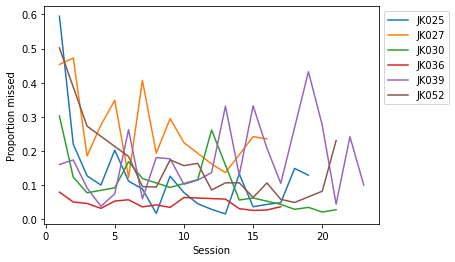

In [147]:
behavior_dir = Path(r'E:\TPM\JK\SoloData')
def get_prop_missed(mouse, session, behavior_dir):
    behavior_fn = behavior_dir / f'JK{mouse:03d}/JK{mouse:03}S{session:02}_behavior.pkl'
    behavior = pd.read_pickle(behavior_fn)
    behavior = behavior.query('trialType != "oo"')
    return len(np.where(behavior.choice.values =='m')[0]) / len(behavior)

fig, ax = plt.subplots()
for mouse in use_mice_df.mouse.unique():
    sessions = np.sort(use_mice_df.query('mouse == @mouse').session.unique().astype(int))
    miss_prop = np.zeros(len(sessions))
    for si, session in enumerate(sessions):
        miss_prop[si] = get_prop_missed(mouse, session, behavior_dir)
    ax.plot(sessions, miss_prop, label=f'JK{mouse:03d}')
ax.set_xlabel('Session')
ax.set_ylabel('Proportion missed')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

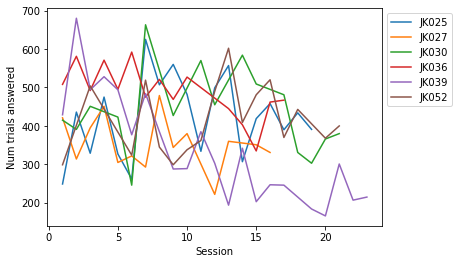

In [148]:
behavior_dir = Path(r'E:\TPM\JK\SoloData')
def get_num_answered(mouse, session, behavior_dir):
    behavior_fn = behavior_dir / f'JK{mouse:03d}/JK{mouse:03}S{session:02}_behavior.pkl'
    behavior = pd.read_pickle(behavior_fn)
    behavior = behavior.query('trialType != "oo"')
    return len(behavior) - len(np.where(behavior.choice.values =='m')[0])

fig, ax = plt.subplots()
for mouse in use_mice_df.mouse.unique():
    sessions = np.sort(use_mice_df.query('mouse == @mouse').session.unique().astype(int))
    num_answered = np.zeros(len(sessions))
    for si, session in enumerate(sessions):
        num_answered[si] = get_num_answered(mouse, session, behavior_dir)
    ax.plot(sessions, num_answered, label=f'JK{mouse:03d}')
ax.set_xlabel('Session')
ax.set_ylabel('Num trials answered')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

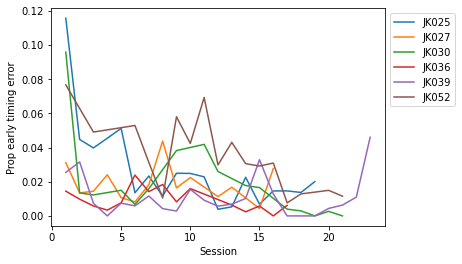

In [173]:
def lick_during_sampling_only(missed_series):
    ''' True if there is a lick during the sampling period
    but not during the answer period
    '''

    lick_times = np.union1d(missed_series.beamBreakTimesLeft, missed_series.beamBreakTimesRight)
    sampling_period_times = missed_series.samplingPeriodTime
    lick_times_after_sampling = lick_times[np.where(lick_times > sampling_period_times[0])[0]]
    lick_times_before_answer = lick_times[np.where(lick_times <= sampling_period_times[-1])[0]]
    if len(np.intersect1d(lick_times_after_sampling,
                          lick_times_before_answer))>0:
        return True
    else:
        return False

def prop_early_timing_error(mouse, session, behavior_dir):
    behavior_fn = behavior_dir / f'JK{mouse:03d}/JK{mouse:03}S{session:02}_behavior.pkl'
    behavior = pd.read_pickle(behavior_fn)
    behavior = behavior.query('trialType != "oo"')
    missed_behavior = behavior.query("choice == 'm'")
    num_missed_timing = np.sum(missed_behavior.apply(lick_during_sampling_only, axis=1))
    num_trials = len(behavior)
    return num_missed_timing / num_trials


fig, ax = plt.subplots()
for mouse in use_mice_df.mouse.unique():
    sessions = np.sort(use_mice_df.query('mouse == @mouse').session.unique().astype(int))
    num_answered = np.zeros(len(sessions))
    for si, session in enumerate(sessions):
        num_answered[si] = prop_early_timing_error(mouse, session, behavior_dir)
    ax.plot(sessions, num_answered, label=f'JK{mouse:03d}')
ax.set_xlabel('Session')
ax.set_ylabel('Prop early timing error')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

In [174]:
behavior.columns

Index(['answerLickTime', 'answerPeriodTime', 'beamBreakTimesLeft',
       'beamBreakTimesRight', 'choice', 'drinkingTime',
       'extraITIOnErrorSetting', 'motorApPosition', 'motorDistance',
       'poleDownOnsetTime', 'poleUpOnsetTime', 'rewardTimeLeft',
       'rewardTimeRight', 'samplingPeriodTime', 'servoAngle', 'trialType',
       'mouse_name', 'session_name', 'session_type', 'task_target',
       'distractor'],
      dtype='object')

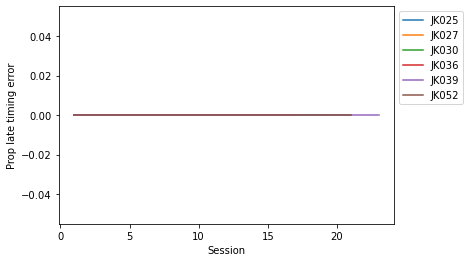

In [175]:
def lick_late_timing_error(missed_series):
    ''' True if there is a lick after the answer period,
    before pole down
    '''
    lick_times = np.union1d(missed_series.beamBreakTimesLeft, missed_series.beamBreakTimesRight)
    last_answer_period_time = missed_series.answerPeriodTime[-1]
    pole_down_time = missed_series.poleDownOnsetTime    
    lick_times_after_answer = lick_times[np.where(lick_times > last_answer_period_time)[0]]
    lick_times_before_poledown = lick_times[np.where(lick_times <= pole_down_time)[0]]
    if len(np.intersect1d(lick_times_after_answer,
                          lick_times_before_poledown))>0:
        return True
    else:
        return False

def prop_late_timing_error(mouse, session, behavior_dir):
    behavior_fn = behavior_dir / f'JK{mouse:03d}/JK{mouse:03}S{session:02}_behavior.pkl'
    behavior = pd.read_pickle(behavior_fn)
    behavior = behavior.query('trialType != "oo"')
    missed_behavior = behavior.query("choice == 'm'")
    num_missed_timing = np.sum(missed_behavior.apply(lick_late_timing_error, axis=1))
    num_trials = len(behavior)
    return num_missed_timing / num_trials


fig, ax = plt.subplots()
for mouse in use_mice_df.mouse.unique():
    sessions = np.sort(use_mice_df.query('mouse == @mouse').session.unique().astype(int))
    num_answered = np.zeros(len(sessions))
    for si, session in enumerate(sessions):
        num_answered[si] = prop_late_timing_error(mouse, session, behavior_dir)
    ax.plot(sessions, num_answered, label=f'JK{mouse:03d}')
ax.set_xlabel('Session')
ax.set_ylabel('Prop late timing error')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

In [189]:
missed_behavior.poleUpOnsetTime.values  


array([1.044829, 1.045496, 1.04548 , 1.045663, 1.045647, 1.04548 ,
       1.045496, 1.045663, 1.045147, 1.045162, 1.046162, 1.045662,
       1.04548 , 1.045829, 1.045829, 1.045495, 1.044814, 1.045163,
       1.045345, 1.04548 , 1.045329, 1.04534 , 1.045511, 1.045162,
       1.044996, 1.045177, 1.045512, 1.045329, 1.044814, 1.04548 ,
       1.044662, 1.045178, 1.045495, 1.045496, 1.044981, 1.045496,
       1.045157, 1.045147, 1.045663, 1.045496, 1.045829, 1.04548 ,
       1.045496, 1.045678, 1.045496, 1.044329, 1.04533 , 1.045329,
       1.045178, 1.045344, 1.045162, 1.045663, 1.045011])

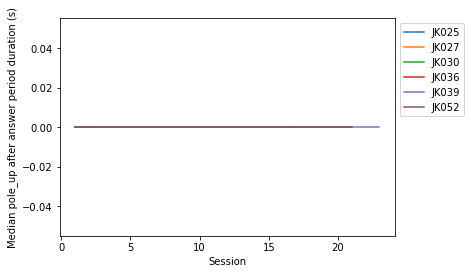

In [191]:
def median_pole_up_after_answer_period_duration(mouse, session, behavior_dir):
    ''' Median duration between the last answer period and pole down
    '''
    behavior_fn = behavior_dir / f'JK{mouse:03d}/JK{mouse:03}S{session:02}_behavior.pkl'
    behavior = pd.read_pickle(behavior_fn)
    behavior = behavior.query('trialType != "oo"')
    missed_behavior = behavior.query("choice == 'm'")

    last_answer_period_time = np.array([x[1] for x in missed_behavior.answerPeriodTime.values])
    pole_down_time = missed_behavior.poleDownOnsetTime.values
    return np.median(pole_down_time - last_answer_period_time)

fig, ax = plt.subplots()
for mouse in use_mice_df.mouse.unique():
    sessions = np.sort(use_mice_df.query('mouse == @mouse').session.unique().astype(int))
    num_answered = np.zeros(len(sessions))
    for si, session in enumerate(sessions):
        num_answered[si] = median_pole_up_after_answer_period_duration(mouse, session, behavior_dir)
    ax.plot(sessions, num_answered, label=f'JK{mouse:03d}')
ax.set_xlabel('Session')
ax.set_ylabel('Median pole_up after answer period duration (s)')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

# There is NO time between the last answer period and pole down during miss trials!



In [105]:
from scripts import design_matrix as dm
mouse = 25
plane = 1
session = 4

plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
behavior_fn = plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl'
if not behavior_fn.exists():
    raise FileNotFoundError(f'{behavior_fn} does not exist')
behavior_frametime = pd.read_pickle(plane_dir / f'JK{mouse:03}_S{session:02}_plane{plane}_frame_whisker_behavior.pkl')
roi_dir = plane_dir / f'{session:03}/plane0/roi'
ophys_fn = roi_dir / 'refined_frame_time.pkl'
if not ophys_fn.exists():
    raise FileNotFoundError(f'{ophys_fn} does not exist')
ophys_frametime = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')

# remove those with remove_trial==True (from expert_mice.csv)
refined_ophys_frametime = ophys_frametime.query('remove_trial==False')
assert refined_ophys_frametime.remove_frame.values.sum() == 0
# extend each trial frames by 1 in each direction (those trimmed to make reduced_frame_time.pkl from frame_time.pkl)
# so that I can have 2 more frame of information (from behavior_frametime)
extended_ophys_df = refined_ophys_frametime.groupby('trialNum').apply(dm.extend_dataframe).reset_index(drop=True)

# merge with behavior_frametime
reduced_behavior_columns = np.setdiff1d(behavior_frametime.columns,
                                        np.setdiff1d(extended_ophys_df.columns,
                                                        ['trialNum', 'frame_index']))
reduced_behavior_df = behavior_frametime[reduced_behavior_columns]
merged_df = pd.merge(extended_ophys_df, reduced_behavior_df,
                        on=['trialNum', 'frame_index'], how='inner')

In [108]:
# remove catch trials
catch_trial_nums = merged_df.query('trial_type == "oo"')['trialNum'].unique()
merged_df = merged_df.query('trialNum not in @catch_trial_nums')
assert 'oo' not in merged_df['trial_type'].unique()

# Assign pole in sound and pole out sound cue frames
assert not merged_df.groupby('trialNum').apply(lambda x: len(np.where(x['pole_up_frame']==1)[0])==0).any()
merged_df['pole_in_frame'] = merged_df.groupby('trialNum').apply(lambda x: x['frame_index'] == x['frame_index'].values[np.where(x['pole_up_frame']==True)[0][0]-1]).reset_index(drop=True).values    
merged_df['pole_out_frame'] = merged_df.groupby('trialNum').apply(dm.apply_pole_out).reset_index(drop=True).values

# Initialize names
angles = merged_df['pole_angle'].unique()
angles = angles[~np.isnan(angles)].astype(int)
lick_names = ['num_lick_left', 'num_lick_right']
whisking_names = ['num_whisks', 'midpoint', 'amplitude']
reward_names = ['first_reward_lick_left', 'first_reward_lick_right']
sound_names = ['pole_in_frame', 'pole_out_frame']
touch_names = []

# add specific angle touch
for angle in angles:
    touch_names.append(f'touch_count_{angle}')
    merged_df[f'touch_count_{angle}'] = np.nan
    merged_df.loc[merged_df['pole_angle']==angle, f'touch_count_{angle}'] = merged_df.loc[merged_df['pole_angle']==angle, 'touch_count'].values
    merged_df[f'touch_count_{angle}'] = merged_df[f'touch_count_{angle}'].apply(lambda x: 0 if np.isnan(x) else x)


In [110]:
merged_df.columns

Index(['trialNum', 'frame_start_time', 'frame_end_time', 'trial_duration',
       'frame_index', 'remove_frame', 'remove_trial', 'amplitude',
       'answer_lick_frame', 'answer_lick_left', 'answer_lick_right',
       'answer_period_frame', 'arc_length_onset', 'correct', 'delta_kappaH',
       'delta_kappaV', 'delta_phi', 'delta_theta', 'distractor',
       'first_reward_lick_frame', 'first_reward_lick_left',
       'first_reward_lick_right', 'kappaH_onset', 'kappaV_onset', 'midpoint',
       'miss', 'mouse_name', 'num_lick_left', 'num_lick_right', 'num_whisks',
       'phi_onset', 'pole_angle', 'pole_ap_distance', 'pole_moving_frame',
       'pole_radial_distance', 'pole_up_frame', 'post_answer_pole_up_frame',
       'pre_answer_pole_up_frame', 'session_name', 'session_type',
       'slide_distance', 'task_target', 'theta', 'theta_onset', 'touch_count',
       'touch_duration', 'trial_type', 'wrong', 'pole_in_frame',
       'pole_out_frame', 'touch_count_90', 'touch_count_105', 'touch

In [111]:
merged_df['answer_period_frame']

0        False
1        False
2        False
3        False
4        False
         ...  
10458    False
10459    False
10460    False
10461    False
10462    False
Name: answer_period_frame, Length: 10463, dtype: bool

# How do VE 0.05 look like?
- compared to 0.01 and 0.1, 0.2, ...
- Follow up in 240220_touch_glm_examples.ipynb